In [1]:
import pandas as pd
import numpy as np
import os
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Embedding, LSTM, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

from keras.optimizers import SGD, Adam

from keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

def train_callbacks(id_model, kpi_to_monitor='val_accuracy'):
    # Without log/ or models/ subfolder as not possible to access unexisting folders
    # If possible to train with jupyter revise
    log_filename = 'fakenews-classifier-model-%s.log' % id_model
    csv_logger = CSVLogger(log_filename)
    
    chk_1_model_filename = 'fakenews-classifier-model-%s-{epoch:04d}-{%s:.6f}.h5' % (id_model, kpi_to_monitor)
    chk_2_model_filename = 'fakenews-classifier-model-%s.h5' % id_model
    
    # Save best model fully not only weights after each epoch (period=1) 
    # with best accuracy value (mode=max, save_best_only=True)
    checkpoint1 = ModelCheckpoint(
        chk_1_model_filename,
        monitor=kpi_to_monitor,
        save_best_only=True,
        save_weights_only=False, 
        verbose=1, mode='max', period=1
    )

    checkpoint2 = ModelCheckpoint(
        chk_2_model_filename, 
        monitor=kpi_to_monitor,
        save_best_only=False,
        save_weights_only=False, 
        verbose=1, mode='auto', period=1
    )

    callbacks = [csv_logger, checkpoint1, checkpoint2]
    return callbacks

def compile_model(model):
    # Default learning rate is 0.001
    model.compile(optimizer=SGD(lr=1.0e-5),
                  loss='categorical_crossentropy',
                  #loss='mse',
                  metrics=['accuracy']
    )
    model.summary()    
    return model

def fit_model(model, id_model, x_train, y_train, x_valid, y_valid, epochs=100):
    model.fit(x=x_train,
              y=y_train,
              epochs=epochs,
              validation_data=(x_valid, y_valid),
              callbacks=train_callbacks(id_model),
              shuffle=True,
              batch_size=100
    )
    return model

def load_news(in_kaggle=False):
    kaggle_path = '/kaggle/input/fake-and-real-news-dataset/Processed_news.csv'
    jupyter_path = 'data/fake-and-real-news-dataset/Processed_news.csv'

    path = kaggle_path if in_kaggle else jupyter_path
    
    clean_data = pd.read_csv(path)
    X = clean_data.clean_text.values
    y = np.array([[1, 0] if category==1 else [0, 1] for category in clean_data.category.values])

    # Train 70% Validation 10% Test 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=21)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def load_liar_news(in_kaggle=False):
    #kaggle_path = '/kaggle/input/fake-and-real-news-dataset/Processed_news.csv'
    train_path = 'data/liar_dataset/Processed_train.csv'
    valid_path = 'data/liar_dataset/Processed_valid.csv'
    test_path = 'data/liar_dataset/Processed_test.csv'
    
    #path = kaggle_path if in_kaggle else jupyter_path
    
    train_data = pd.read_csv(train_path)
    valid_data = pd.read_csv(valid_path)
    test_data = pd.read_csv(test_path)
    
    X_train, X_valid, X_test = train_data.clean_text.values, valid_data.clean_text.values, test_data.clean_text.values
    y_train = np.array([[1, 0] if category==1 else [0, 1] for category in train_data.category.values])
    y_valid = np.array([[1, 0] if category==1 else [0, 1] for category in valid_data.category.values])
    y_test = np.array([[1, 0] if category==1 else [0, 1] for category in test_data.category.values])
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def load_liar_news_100(in_kaggle=False):        
    train_path = 'data/liar_dataset/Processed_train_100.csv'
    valid_path = 'data/liar_dataset/Processed_valid_100.csv'
    test_path = 'data/liar_dataset/Processed_test_100.csv'
    
    train_data = pd.read_csv(train_path)
    valid_data = pd.read_csv(valid_path)
    test_data = pd.read_csv(test_path)
    
    X_train, X_valid, X_test = train_data.clean_text.values, valid_data.clean_text.values, test_data.clean_text.values
    y_train = np.array([[1, 0] if category==1 else [0, 1] for category in train_data.category.values])
    y_valid = np.array([[1, 0] if category==1 else [0, 1] for category in valid_data.category.values])
    y_test = np.array([[1, 0] if category==1 else [0, 1] for category in test_data.category.values])
        
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def to_int_seq(x_train, x_valid, x_test, max_length, max_words=10000, oov_tok='<OOV>', trunc_type='post', pad_type='post'):
    
    # max_words = max_words + 1 As padding is added as 0
    max_words = max_words - 1
    # Assign id to tokens
    tokenizer = Tokenizer(num_words=max_words, oov_token=oov_tok)
    tokenizer.fit_on_texts(x_train)

    train_sequences = tokenizer.texts_to_sequences(x_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_length,
                                 padding=pad_type,
                                 truncating=trunc_type)

    valid_sequences = tokenizer.texts_to_sequences(x_valid)
    valid_padded = pad_sequences(valid_sequences,
                                 maxlen=max_length,
                                 padding=pad_type,
                                 truncating=trunc_type)
    
    test_sequences = tokenizer.texts_to_sequences(x_test)
    test_padded = pad_sequences(test_sequences,
                                maxlen=max_length,
                                padding=pad_type,
                                truncating=trunc_type)
    
    return train_padded, valid_padded, test_padded

def evaluate_model(model, x_test, y_test, history, subsamples=False):
    
    # Accuracy & Loss graphs
    loss, accuracy = model.evaluate(x_test, y_test)
    
    plot_acc(history.accuracy, history.val_accuracy, [accuracy])
    plot_loss(history.loss, history.val_loss, [loss])
    
    # Precision, Recall, F1-score, ROC curve and Area under ROC curve
    pred = model.predict(x_test)
    
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(pred, axis=1)
    
    auroc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plot_roc_curve(fpr, tpr, auroc)
        
    print(classification_report(y_test, y_pred))
    print()
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    print("ROC-AUC Score:", auroc)
    
    new_pred = []    
    if subsamples == True: 
        test_data = pd.read_csv('data/liar_dataset/Processed_test_100.csv')
        
        for nid in list(set(test_data.news_id.values)):
            indices = list(test_data[test_data.news_id == nid].index)
            if len(indices) == 1:
                new_pred.append(pred[indices[0]])
            else:
                new_pred.append(sum([pred[i] for i in indices])/len(indices))
    
        y_new_pred = np.argmax(pred, axis=1)
        y_new_test = test_data.category.values
        print()
        print(classification_report(y_new_test, y_new_pred))
        print()
        c = 0
        for i in range(len(y_new_pred)):
            if y_new_pred[i] == y_new_test[i]:
                c = c+1
        print('Test Accuracy Combining samples:', c/len(y_new_pred))

def plot_acc(train_acc, val_acc, test_acc):
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.plot(test_acc*len(train_acc))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val', 'test'], loc='best')
    plt.show()

def plot_loss(train_loss, val_loss, test_loss):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.plot(test_loss*len(train_loss))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val', 'test'], loc='best')
    plt.show()
    
def plot_roc_curve(fpr, tpr, auroc):
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area={:.4f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Using TensorFlow backend.


In [2]:
def set_gpu( id_gpu="0" ):
    #
    os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID";
    os.environ['CUDA_VISIBLE_DEVICES']=id_gpu;
    #
    #config = tf.ConfigProto()
    #config.gpu_options.allow_growth=True
    #sess = tf.Session(config=config)
    #
    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth( gpus[0], True)
    
set_gpu()

In [3]:
# Load real-fake-news
X_train, X_valid, X_test, y_train, y_valid, y_test = load_news()

In [4]:
vocab_size = 10000
max_length = 700
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

In [17]:
# Load liar-news
X_train, X_valid, X_test, y_train, y_valid, y_test = load_liar_news()

In [29]:
vocab_size = 10000
max_length = 50
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

In [21]:
# Load liar-news-30
X_train, X_valid, X_test, y_train, y_valid, y_test = load_liar_news_100()

In [22]:
vocab_size = 10000
max_length = 30
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

In [8]:
embedding_matrix_liar_news = np.load('embedding_matrix_liar_news.npy')

In [ ]:
# REAL = 0
# FAKE = 1

In [5]:
embedding_matrix_liar_news = np.load('embedding_matrix_fake_news.npy')

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 150)          1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 1,917,282
Trainable params: 1,917,282
Non-trainable params: 0
_________________________________________________________________


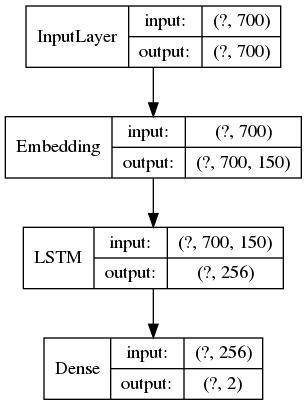

In [5]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(256))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

## Pruebas Mod 2

In [4]:
train_data = pd.read_csv('data/liar_dataset/Processed_train2.csv')
valid_data = pd.read_csv('data/liar_dataset/Processed_valid2.csv')
test_data = pd.read_csv('data/liar_dataset/Processed_test2.csv')

X_train, X_valid, X_test = train_data.clean_text.values, valid_data.clean_text.values, test_data.clean_text.values

y_train = np.array([[1, 0] if category==1 else [0, 1] for category in train_data.category.values])
y_valid = np.array([[1, 0] if category==1 else [0, 1] for category in valid_data.category.values])
y_test = np.array([[1, 0] if category==1 else [0, 1] for category in test_data.category.values])

In [5]:
vocab_size = 10000
max_length = 30
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

In [72]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(256))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'modelo_A-v2', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_33 (LSTM)               (None, 256)               416768    
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 514       
Total params: 1,917,282
Trainable params: 1,917,282
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10241 samples, validate on 1284 samples
Epoch 1/100
10241/10241 [==============================] - 7s 664us/step - loss: 0.6926 - accuracy: 0.5487 - val_loss: 0.6929 - val_accuracy: 0.5086

Epoch 00001: val_accuracy improved from -inf to 0.50857, saving model to fakenews-classifier-model-modelo_A-v2-0001-0.508567.h5

Epoch 00001: saving model to fakenews-classifier-model-modelo_A-v2.h5
Epoch 2/100
10241/10241 [==============================] - 6s 584us/step - loss: 0.6926 - accuracy: 0.5503 - val_loss: 0.6929 - val_accuracy: 0.5093

Epoch 00002: val_accuracy improved from 0.50857 to 0.50935, saving model to fakenews-classifier-model-modelo_A-v2-0002-0.509346.h5

Epoch 00002: saving model to fakenews-classifier-model-modelo_A-v2.h5
Epoch 3/100
10241/10241 [==============================] - 6s 590us/step - loss: 0.6926 - accuracy: 0.5504 - val_loss: 0.6929 - val_accuracy: 0.5148

Epoch 00003: val_accuracy improved from 0.50935 to 0.51480, saving model to fakenews-classifier-mode

10241/10241 [==============================] - 6s 560us/step - loss: 0.6921 - accuracy: 0.5621 - val_loss: 0.6927 - val_accuracy: 0.5226

Epoch 00028: val_accuracy did not improve from 0.52259

Epoch 00028: saving model to fakenews-classifier-model-modelo_A-v2.h5
Epoch 29/100
10241/10241 [==============================] - 6s 566us/step - loss: 0.6921 - accuracy: 0.5622 - val_loss: 0.6927 - val_accuracy: 0.5234

Epoch 00029: val_accuracy improved from 0.52259 to 0.52336, saving model to fakenews-classifier-model-modelo_A-v2-0029-0.523364.h5

Epoch 00029: saving model to fakenews-classifier-model-modelo_A-v2.h5
Epoch 30/100
10241/10241 [==============================] - 6s 563us/step - loss: 0.6921 - accuracy: 0.5625 - val_loss: 0.6927 - val_accuracy: 0.5234

Epoch 00030: val_accuracy did not improve from 0.52336

Epoch 00030: saving model to fakenews-classifier-model-modelo_A-v2.h5
Epoch 31/100
10241/10241 [==============================] - 6s 571us/step - loss: 0.6920 - accuracy: 0.562

KeyboardInterrupt: 

In [73]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'modelo_B-v2', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_34 (LSTM)               (None, 30, 128)           142848    
_________________________________________________________________
lstm_35 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 258       
Total params: 1,774,690
Trainable params: 1,774,690
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10241 samples, validate on 1284 samples
Epoch 1/100
10241/10241 [==============================] - 11s 1ms/step - loss: 0.6934 - accuracy: 0.4753 - val_loss: 0.6933 - val_accuracy: 0.4618

Epoch 00001: val_accuracy improved from -inf to 0.46184, saving model to fakenews-classifier-model-modelo_B-v2-0001-0.461838.h5

Epoch 00001: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 2/100
10241/10241 [==============================] - 9s 884us/step - loss: 0.6934 - accuracy: 0.4786 - val_loss: 0.6933 - val_accuracy: 0.4657

Epoch 00002: val_accuracy improved from 0.46184 to 0.46573, saving model to fakenews-classifier-model-modelo_B-v2-0002-0.465732.h5

Epoch 00002: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 3/100
10241/10241 [==============================] - 9s 870us/step - loss: 0.6933 - accuracy: 0.4806 - val_loss: 0.6933 - val_accuracy: 0.4712

Epoch 00003: val_accuracy improved from 0.46573 to 0.47118, saving model to fakenews-classifier-model


Epoch 00025: val_accuracy did not improve from 0.53193

Epoch 00025: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 26/100
10241/10241 [==============================] - 9s 873us/step - loss: 0.6927 - accuracy: 0.5443 - val_loss: 0.6931 - val_accuracy: 0.5148

Epoch 00026: val_accuracy did not improve from 0.53193

Epoch 00026: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 27/100
10241/10241 [==============================] - 9s 905us/step - loss: 0.6927 - accuracy: 0.5457 - val_loss: 0.6930 - val_accuracy: 0.5164

Epoch 00027: val_accuracy did not improve from 0.53193

Epoch 00027: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 28/100
10241/10241 [==============================] - 9s 885us/step - loss: 0.6926 - accuracy: 0.5478 - val_loss: 0.6930 - val_accuracy: 0.5210

Epoch 00028: val_accuracy did not improve from 0.53193

Epoch 00028: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 29/100
10241/10241 [================

10241/10241 [==============================] - 9s 853us/step - loss: 0.6913 - accuracy: 0.5618 - val_loss: 0.6926 - val_accuracy: 0.5210

Epoch 00085: val_accuracy did not improve from 0.53193

Epoch 00085: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 86/100
10241/10241 [==============================] - 9s 847us/step - loss: 0.6912 - accuracy: 0.5618 - val_loss: 0.6926 - val_accuracy: 0.5210

Epoch 00086: val_accuracy did not improve from 0.53193

Epoch 00086: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 87/100
10241/10241 [==============================] - 9s 845us/step - loss: 0.6912 - accuracy: 0.5618 - val_loss: 0.6926 - val_accuracy: 0.5210

Epoch 00087: val_accuracy did not improve from 0.53193

Epoch 00087: saving model to fakenews-classifier-model-modelo_B-v2.h5
Epoch 88/100
10241/10241 [==============================] - 9s 852us/step - loss: 0.6912 - accuracy: 0.5618 - val_loss: 0.6926 - val_accuracy: 0.5210

Epoch 00088: val_accuracy did n

In [71]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Conv1D(filters=64, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(filters=128, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(filters=128, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

#model.add(Conv1D(filters=128, kernel_size=5, activation=None))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling1D())

model.add(GlobalMaxPooling1D())
#model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'modelo_E', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 26, 64)            48064     
_________________________________________________________________
batch_normalization_49 (Batc (None, 26, 64)            256       
_________________________________________________________________
activation_37 (Activation)   (None, 26, 64)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 22, 128)           41088     
_________________________________________________________________
batch_normalization_50 (Batc (None, 22, 128)           512       
_________________________________________________________________
activation_38 (Activation)   (None, 22, 128)         

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10241 samples, validate on 1284 samples
Epoch 1/100
10241/10241 [==============================] - 3s 256us/step - loss: 0.9607 - accuracy: 0.5000 - val_loss: 0.7762 - val_accuracy: 0.5202

Epoch 00001: val_accuracy improved from -inf to 0.52025, saving model to fakenews-classifier-model-modelo_E-0001-0.520249.h5

Epoch 00001: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 2/100
10241/10241 [==============================] - 2s 160us/step - loss: 0.9574 - accuracy: 0.4998 - val_loss: 0.8026 - val_accuracy: 0.5202

Epoch 00002: val_accuracy did not improve from 0.52025

Epoch 00002: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 3/100
10241/10241 [==============================] - 2s 163us/step - loss: 0.9547 - accuracy: 0.4987 - val_loss: 0.7860 - val_accuracy: 0.5202

Epoch 00003: val_accuracy did not improve from 0.52025

Epoch 00003: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 4/100
10241/10241 [==============================] - 2s 


Epoch 00030: val_accuracy did not improve from 0.52025

Epoch 00030: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 31/100
10241/10241 [==============================] - 2s 162us/step - loss: 0.8912 - accuracy: 0.5154 - val_loss: 0.9257 - val_accuracy: 0.4992

Epoch 00031: val_accuracy did not improve from 0.52025

Epoch 00031: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 32/100
10241/10241 [==============================] - 2s 161us/step - loss: 0.8917 - accuracy: 0.5176 - val_loss: 0.9246 - val_accuracy: 0.4984

Epoch 00032: val_accuracy did not improve from 0.52025

Epoch 00032: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 33/100
10241/10241 [==============================] - 2s 161us/step - loss: 0.8877 - accuracy: 0.5171 - val_loss: 0.9240 - val_accuracy: 0.4961

Epoch 00033: val_accuracy did not improve from 0.52025

Epoch 00033: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 34/100
10241/10241 [============================


Epoch 00060: val_accuracy did not improve from 0.52025

Epoch 00060: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 61/100
10241/10241 [==============================] - 2s 163us/step - loss: 0.8434 - accuracy: 0.5373 - val_loss: 0.9027 - val_accuracy: 0.5023

Epoch 00061: val_accuracy did not improve from 0.52025

Epoch 00061: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 62/100
10241/10241 [==============================] - 2s 161us/step - loss: 0.8414 - accuracy: 0.5351 - val_loss: 0.9021 - val_accuracy: 0.5047

Epoch 00062: val_accuracy did not improve from 0.52025

Epoch 00062: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 63/100
10241/10241 [==============================] - 2s 161us/step - loss: 0.8443 - accuracy: 0.5334 - val_loss: 0.9013 - val_accuracy: 0.5031

Epoch 00063: val_accuracy did not improve from 0.52025

Epoch 00063: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 64/100
10241/10241 [============================


Epoch 00090: val_accuracy did not improve from 0.52025

Epoch 00090: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 91/100
10241/10241 [==============================] - 2s 160us/step - loss: 0.8080 - accuracy: 0.5509 - val_loss: 0.8897 - val_accuracy: 0.5016

Epoch 00091: val_accuracy did not improve from 0.52025

Epoch 00091: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 92/100
10241/10241 [==============================] - 2s 160us/step - loss: 0.8087 - accuracy: 0.5495 - val_loss: 0.8888 - val_accuracy: 0.5031

Epoch 00092: val_accuracy did not improve from 0.52025

Epoch 00092: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 93/100
10241/10241 [==============================] - 2s 160us/step - loss: 0.8069 - accuracy: 0.5487 - val_loss: 0.8883 - val_accuracy: 0.5047

Epoch 00093: val_accuracy did not improve from 0.52025

Epoch 00093: saving model to fakenews-classifier-model-modelo_E.h5
Epoch 94/100
10241/10241 [============================

1267/1267 [==============================] - 3s 3ms/sample - loss: 0.7372 - accuracy: 0.5635


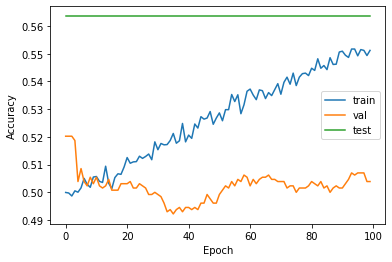

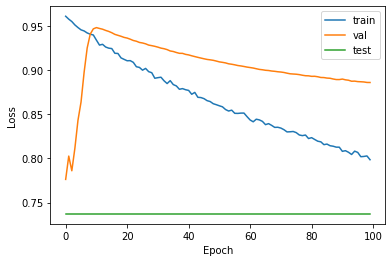

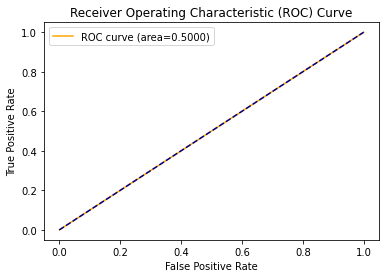

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       553
           1       0.56      1.00      0.72       714

    accuracy                           0.56      1267
   macro avg       0.28      0.50      0.36      1267
weighted avg       0.32      0.56      0.41      1267


Test Loss: 0.7372339618140162
Test Accuracy: 0.5635359
ROC-AUC Score: 0.5
Best model's epoch: 1


/home/david/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
history = pd.read_csv("model-weights/liarDataset/model_E/fakenews-classifier-model-modelo_E.log")
model = load_model("model-weights/liarDataset/model_E/fakenews-classifier-model-modelo_E-0001-0.520249.h5")

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Conv1D(filters=32, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(LSTM(128))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'modelo_F', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 46, 32)            24032     
_________________________________________________________________
batch_normalization_29 (Batc (None, 46, 32)            128       
_________________________________________________________________
activation_22 (Activation)   (None, 46, 32)            0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 19, 64)            10304     
_________________________________________________________________
batch_normalization_30 (Batc (None, 19, 64)          

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10241 samples, validate on 1284 samples
Epoch 1/100
10241/10241 [==============================] - 4s 396us/step - loss: 0.7240 - accuracy: 0.4831 - val_loss: 0.6929 - val_accuracy: 0.5202

Epoch 00001: val_accuracy improved from -inf to 0.52025, saving model to fakenews-classifier-model-modelo_F-0001-0.520249.h5

Epoch 00001: saving model to fakenews-classifier-model-modelo_F.h5
Epoch 2/100
10241/10241 [==============================] - 2s 225us/step - loss: 0.7231 - accuracy: 0.4824 - val_loss: 0.6930 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.52025

Epoch 00002: saving model to fakenews-classifier-model-modelo_F.h5
Epoch 3/100
10241/10241 [==============================] - 2s 229us/step - loss: 0.7226 - accuracy: 0.4813 - val_loss: 0.6947 - val_accuracy: 0.4891

Epoch 00003: val_accuracy did not improve from 0.52025

Epoch 00003: saving model to fakenews-classifier-model-modelo_F.h5
Epoch 4/100
10241/10241 [==============================] - 2s 

KeyboardInterrupt: 

## New models

In [4]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(256, return_sequences = False)) # activation='relu'
model.add(Dense(2, activation='softmax'))
model = compile_model(model)

model = fit_model(model, 'lstm-256', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 1,917,282
Trainable params: 1,917,282
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8127 samples, validate on 1036 samples
Epoch 1/100
8127/8127 [==============================] - 6s 774us/step - loss: 0.6932 - accuracy: 0.4935 - val_loss: 0.6934 - val_accuracy: 0.4643

Epoch 00001: val_accuracy improved from -inf to 0.46429, saving model to fakenews-classifier-model-lstm-256-0001-0.464286.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 2/100
8127/8127 [==============================] - 5s 587us/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6934 - val_accuracy: 0.4662

Epoch 00002: val_accuracy improved from 0.46429 to 0.46622, saving model to fakenews-classifier-model-lstm-256-0002-0.466216.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 3/100
8127/8127 [==============================] - 5s 560us/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4701

Epoch 00003: val_accuracy improved from 0.46622 to 0.47008, saving model to fakenews-classifier-model-lstm-256-0003-0.4


Epoch 00052: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 53/100
8127/8127 [==============================] - 4s 551us/step - loss: 0.6926 - accuracy: 0.5458 - val_loss: 0.6923 - val_accuracy: 0.5878

Epoch 00053: val_accuracy improved from 0.58205 to 0.58784, saving model to fakenews-classifier-model-lstm-256-0053-0.587838.h5

Epoch 00053: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 54/100
8127/8127 [==============================] - 4s 548us/step - loss: 0.6926 - accuracy: 0.5473 - val_loss: 0.6923 - val_accuracy: 0.5907

Epoch 00054: val_accuracy improved from 0.58784 to 0.59073, saving model to fakenews-classifier-model-lstm-256-0054-0.590734.h5

Epoch 00054: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 55/100
8127/8127 [==============================] - 5s 554us/step - loss: 0.6926 - accuracy: 0.5471 - val_loss: 0.6923 - val_accuracy: 0.5907

Epoch 00055: val_accuracy did not improve from 0.59073

Epoch 00055: saving model to fakenews

Epoch 80/100
8127/8127 [==============================] - 4s 548us/step - loss: 0.6923 - accuracy: 0.5525 - val_loss: 0.6918 - val_accuracy: 0.6033

Epoch 00080: val_accuracy did not improve from 0.60521

Epoch 00080: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 81/100
8127/8127 [==============================] - 4s 545us/step - loss: 0.6923 - accuracy: 0.5530 - val_loss: 0.6918 - val_accuracy: 0.6042

Epoch 00081: val_accuracy did not improve from 0.60521

Epoch 00081: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 82/100
8127/8127 [==============================] - 4s 545us/step - loss: 0.6923 - accuracy: 0.5533 - val_loss: 0.6917 - val_accuracy: 0.6004

Epoch 00082: val_accuracy did not improve from 0.60521

Epoch 00082: saving model to fakenews-classifier-model-lstm-256.h5
Epoch 83/100
8127/8127 [==============================] - 5s 556us/step - loss: 0.6923 - accuracy: 0.5526 - val_loss: 0.6917 - val_accuracy: 0.5985

Epoch 00083: val_accuracy did not i

1002/1002 [==============================] - 1s 715us/sample - loss: 0.6924 - accuracy: 0.5499


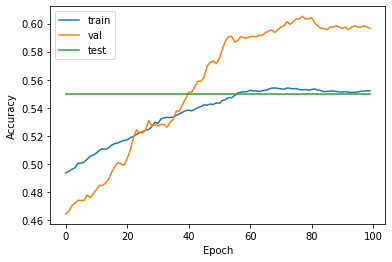

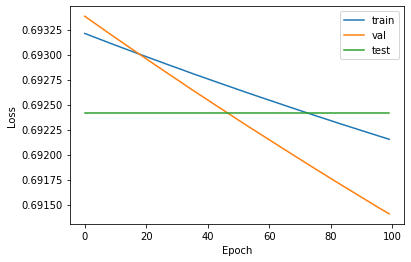

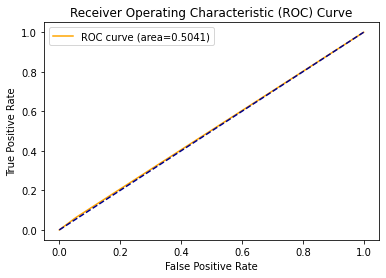

              precision    recall  f1-score   support

           0       0.55      0.95      0.70       553
           1       0.48      0.06      0.11       449

    accuracy                           0.55      1002
   macro avg       0.52      0.50      0.40      1002
weighted avg       0.52      0.55      0.44      1002


Test Loss: 0.6924125352305567
Test Accuracy: 0.5499002
ROC-AUC Score: 0.5040556269306516
Best model's epoch: 78


In [5]:
history = pd.read_csv("model-weights/liarDataset/lstm-256-v2/fakenews-classifier-model-lstm-256.log")
model = load_model("model-weights/liarDataset/lstm-256-v2/fakenews-classifier-model-lstm-256-0078-0.605212.h5")

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 78)

In [25]:
train_data = pd.read_csv('data/liar_dataset/Processed_train2.csv')
valid_data = pd.read_csv('data/liar_dataset/Processed_valid2.csv')
test_data = pd.read_csv('data/liar_dataset/Processed_test2.csv')

X_train, X_valid, X_test = train_data.clean_text.values, valid_data.clean_text.values, test_data.clean_text.values
X = np.concatenate((X_train, X_valid, X_test), axis=None)

y_train = np.array([[1, 0] if category==1 else [0, 1] for category in train_data.category.values])
y_valid = np.array([[1, 0] if category==1 else [0, 1] for category in valid_data.category.values])
y_test = np.array([[1, 0] if category==1 else [0, 1] for category in test_data.category.values])
y = np.concatenate((y_train, y_valid, y_test), axis=0)

# Train 80% Validation 10% Test 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=21)

8127 1036 1002
8127 1036 1002


(10165, 10165)

In [26]:
vocab_size = 10000
max_length = 30
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

## Model Review

In [3]:
train_data = pd.read_csv('data/liar_dataset/Processed_train2.csv')
valid_data = pd.read_csv('data/liar_dataset/Processed_valid2.csv')
test_data = pd.read_csv('data/liar_dataset/Processed_test2.csv')

X_train, X_valid, X_test = train_data.clean_text.values, valid_data.clean_text.values, test_data.clean_text.values
y_train = np.array([[1, 0] if category==1 else [0, 1] for category in train_data.category.values])
y_valid = np.array([[1, 0] if category==1 else [0, 1] for category in valid_data.category.values])
y_test = np.array([[1, 0] if category==1 else [0, 1] for category in test_data.category.values])

vocab_size = 10000
max_length = 30
train_padded, valid_padded, test_padded = to_int_seq(X_train, X_valid, X_test, max_words=vocab_size, max_length=max_length)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
#model.add(Dropout(rate=0.15))
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(LSTM(128, return_sequences = True, activation='relu'))
model.add(LSTM(128, return_sequences = False)) # activation='relu'
#model.add(Flatten())
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))
model = compile_model(model)

model = fit_model(model, 'lstm-256', train_padded, y_train, valid_padded, y_valid)

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
#model.add(Dropout(rate=0.15))
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(LSTM(128, return_sequences = True, activation='relu'))
model.add(LSTM(128, return_sequences = False)) # activation='relu'
#model.add(Flatten())
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
#model.add(Dense(1, activation='sigmoid'))
model = compile_model(model)

model = fit_model(model, 'lstm-128', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               142848    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 1,643,106
Trainable params: 1,643,106
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8127 samples, validate on 1036 samples
Epoch 1/100
8127/8127 [==============================] - 4s 545us/step - loss: 0.6928 - accuracy: 0.5301 - val_loss: 0.6926 - val_accuracy: 0.5376

Epoch 00001: val_accuracy improved from -inf to 0.53764, saving model to fakenews-classifier-model-lstm-128-0001-0.537645.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 2/100
8127/8127 [==============================] - 4s 449us/step - loss: 0.6928 - accuracy: 0.5311 - val_loss: 0.6926 - val_accuracy: 0.5386

Epoch 00002: val_accuracy improved from 0.53764 to 0.53861, saving model to fakenews-classifier-model-lstm-128-0002-0.538610.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 3/100
8127/8127 [==============================] - 4s 448us/step - loss: 0.6927 - accuracy: 0.5318 - val_loss: 0.6926 - val_accuracy: 0.5396

Epoch 00003: val_accuracy improved from 0.53861 to 0.53958, saving model to fakenews-classifier-model-lstm-128-0003-0.5


Epoch 00026: val_accuracy did not improve from 0.56660

Epoch 00026: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 27/100
8127/8127 [==============================] - 4s 456us/step - loss: 0.6925 - accuracy: 0.5409 - val_loss: 0.6920 - val_accuracy: 0.5676

Epoch 00027: val_accuracy improved from 0.56660 to 0.56757, saving model to fakenews-classifier-model-lstm-128-0027-0.567568.h5

Epoch 00027: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 28/100
8127/8127 [==============================] - 4s 459us/step - loss: 0.6924 - accuracy: 0.5415 - val_loss: 0.6920 - val_accuracy: 0.5695

Epoch 00028: val_accuracy improved from 0.56757 to 0.56950, saving model to fakenews-classifier-model-lstm-128-0028-0.569498.h5

Epoch 00028: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 29/100
8127/8127 [==============================] - 4s 445us/step - loss: 0.6924 - accuracy: 0.5418 - val_loss: 0.6920 - val_accuracy: 0.5705

Epoch 00029: val_accuracy improved fr


Epoch 00053: val_accuracy did not improve from 0.58784

Epoch 00053: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 54/100
8127/8127 [==============================] - 4s 441us/step - loss: 0.6922 - accuracy: 0.5472 - val_loss: 0.6915 - val_accuracy: 0.5878

Epoch 00054: val_accuracy did not improve from 0.58784

Epoch 00054: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 55/100
8127/8127 [==============================] - 4s 439us/step - loss: 0.6922 - accuracy: 0.5468 - val_loss: 0.6914 - val_accuracy: 0.5898

Epoch 00055: val_accuracy improved from 0.58784 to 0.58977, saving model to fakenews-classifier-model-lstm-128-0055-0.589768.h5

Epoch 00055: saving model to fakenews-classifier-model-lstm-128.h5
Epoch 56/100
8127/8127 [==============================] - 4s 440us/step - loss: 0.6921 - accuracy: 0.5469 - val_loss: 0.6914 - val_accuracy: 0.5898

Epoch 00056: val_accuracy did not improve from 0.58977

Epoch 00056: saving model to fakenews-classifier-model

1002/1002 [==============================] - 0s 378us/sample - loss: 0.6921 - accuracy: 0.5529


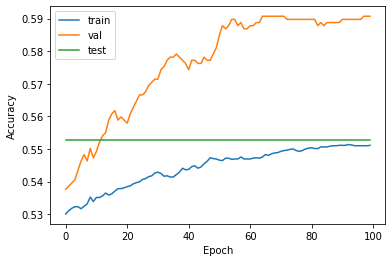

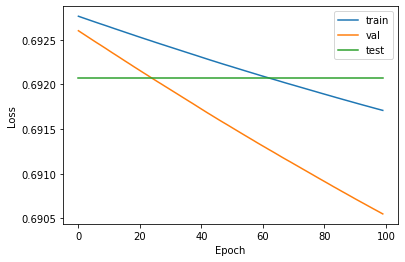

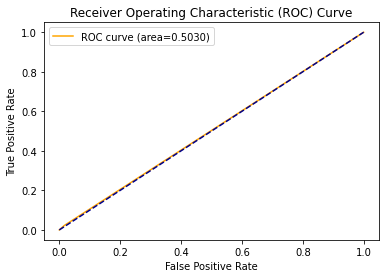

              precision    recall  f1-score   support

           0       0.55      0.98      0.71       553
           1       0.53      0.02      0.04       449

    accuracy                           0.55      1002
   macro avg       0.54      0.50      0.38      1002
weighted avg       0.54      0.55      0.41      1002


Test Loss: 0.6920763394551839
Test Accuracy: 0.55289423
ROC-AUC Score: 0.5029984252729593
Best model's epoch: 65


In [34]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-especial/fakenews-classifier-model-lstm-128.log")
model = load_model("model-weights/liarDataset/lstm-128-especial/fakenews-classifier-model-lstm-128-0065-0.590734.h5")

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 65)

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))

model.add(LSTM(128, return_sequences = False, activation='relu'))

model.add(Dense(2, activation='softmax'))
model = compile_model(model)

model = fit_model(model, 'lstm-128-relu', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               142848    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 1,643,106
Trainable params: 1,643,106
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8127 samples, validate on 1036 samples
Epoch 1/100
8127/8127 [==============================] - 4s 535us/step - loss: 0.6929 - accuracy: 0.5311 - val_loss: 0.6926 - val_accuracy: 0.5627

Epoch 00001: val_accuracy improved from -inf to 0.56274, saving model to fakenews-classifier-model-lstm-128-relu-0001-0.562741.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-128-relu.h5
Epoch 2/100
8127/8127 [==============================] - 4s 458us/step - loss: 0.6929 - accuracy: 0.5307 - val_loss: 0.6926 - val_accuracy: 0.5637

Epoch 00002: val_accuracy improved from 0.56274 to 0.56371, saving model to fakenews-classifier-model-lstm-128-relu-0002-0.563707.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-128-relu.h5
Epoch 3/100
8127/8127 [==============================] - 4s 443us/step - loss: 0.6929 - accuracy: 0.5298 - val_loss: 0.6926 - val_accuracy: 0.5618

Epoch 00003: val_accuracy did not improve from 0.56371

Epoch 00003: saving model to fakenews-class

8127/8127 [==============================] - 4s 433us/step - loss: 0.6926 - accuracy: 0.5483 - val_loss: 0.6920 - val_accuracy: 0.5994

Epoch 00055: val_accuracy did not improve from 0.60232

Epoch 00055: saving model to fakenews-classifier-model-lstm-128-relu.h5
Epoch 56/100
8127/8127 [==============================] - 4s 432us/step - loss: 0.6926 - accuracy: 0.5489 - val_loss: 0.6920 - val_accuracy: 0.6014

Epoch 00056: val_accuracy did not improve from 0.60232

Epoch 00056: saving model to fakenews-classifier-model-lstm-128-relu.h5
Epoch 57/100
8127/8127 [==============================] - 4s 438us/step - loss: 0.6926 - accuracy: 0.5494 - val_loss: 0.6920 - val_accuracy: 0.6033

Epoch 00057: val_accuracy improved from 0.60232 to 0.60328, saving model to fakenews-classifier-model-lstm-128-relu-0057-0.603282.h5

Epoch 00057: saving model to fakenews-classifier-model-lstm-128-relu.h5
Epoch 58/100
8127/8127 [==============================] - 4s 433us/step - loss: 0.6926 - accuracy: 0.550

1002/1002 [==============================] - 0s 446us/sample - loss: 0.6925 - accuracy: 0.5589


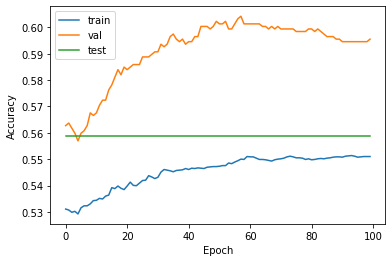

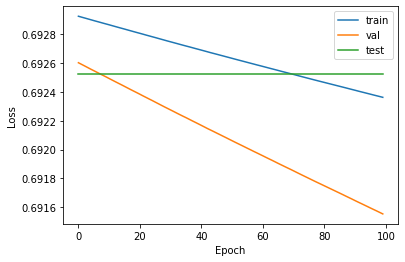

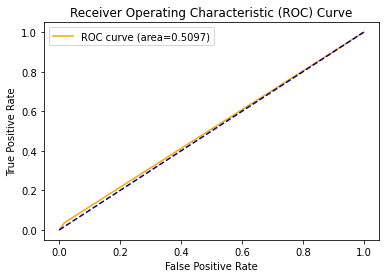

              precision    recall  f1-score   support

           0       0.56      0.98      0.71       553
           1       0.64      0.04      0.07       449

    accuracy                           0.56      1002
   macro avg       0.60      0.51      0.39      1002
weighted avg       0.59      0.56      0.42      1002


Test Loss: 0.6925242730005534
Test Accuracy: 0.55888224
ROC-AUC Score: 0.5096799397495742
Best model's epoch: 58


In [33]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-especial-relu/fakenews-classifier-model-lstm-128-relu.log")
model = load_model("model-weights/liarDataset/lstm-128-especial-relu/fakenews-classifier-model-lstm-128-relu-0058-0.604247.h5")

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 58)

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
#model.add(Dropout(rate=0.15))
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(LSTM(128, return_sequences = True, activation='relu'))
model.add(LSTM(512, return_sequences = False)) # activation='relu'
#model.add(Flatten())
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)

model = fit_model(model, 'lstm-512', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 512)               1357824   
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 1026      
Total params: 2,858,850
Trainable params: 2,858,850
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8127 samples, validate on 1036 samples
Epoch 1/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6929 - accuracy: 0.5270 - val_loss: 0.6929 - val_accuracy: 0.5357

Epoch 00001: val_accuracy improved from -inf to 0.53571, saving model to fakenews-classifier-model-lstm-512-0001-0.535714.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 2/100
8127/8127 [==============================] - 8s 981us/step - loss: 0.6929 - accuracy: 0.5280 - val_loss: 0.6929 - val_accuracy: 0.5396

Epoch 00002: val_accuracy improved from 0.53571 to 0.53958, saving model to fakenews-classifier-model-lstm-512-0002-0.539575.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 3/100
8127/8127 [==============================] - 8s 1ms/step - loss: 0.6929 - accuracy: 0.5281 - val_loss: 0.6928 - val_accuracy: 0.5425

Epoch 00003: val_accuracy improved from 0.53958 to 0.54247, saving model to fakenews-classifier-model-lstm-512-0003-0.54247

8127/8127 [==============================] - 9s 1ms/step - loss: 0.6926 - accuracy: 0.5466 - val_loss: 0.6923 - val_accuracy: 0.5869

Epoch 00027: val_accuracy improved from 0.58591 to 0.58687, saving model to fakenews-classifier-model-lstm-512-0027-0.586873.h5

Epoch 00027: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 28/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6926 - accuracy: 0.5472 - val_loss: 0.6923 - val_accuracy: 0.5878

Epoch 00028: val_accuracy improved from 0.58687 to 0.58784, saving model to fakenews-classifier-model-lstm-512-0028-0.587838.h5

Epoch 00028: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 29/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6926 - accuracy: 0.5478 - val_loss: 0.6923 - val_accuracy: 0.5917

Epoch 00029: val_accuracy improved from 0.58784 to 0.59170, saving model to fakenews-classifier-model-lstm-512-0029-0.591699.h5

Epoch 00029: saving model to fakenews-classifier-mo

8127/8127 [==============================] - 8s 1ms/step - loss: 0.6923 - accuracy: 0.5525 - val_loss: 0.6917 - val_accuracy: 0.5917

Epoch 00056: val_accuracy did not improve from 0.59459

Epoch 00056: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 57/100
8127/8127 [==============================] - 8s 1ms/step - loss: 0.6923 - accuracy: 0.5526 - val_loss: 0.6917 - val_accuracy: 0.5917

Epoch 00057: val_accuracy did not improve from 0.59459

Epoch 00057: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 58/100
8127/8127 [==============================] - 8s 1ms/step - loss: 0.6923 - accuracy: 0.5525 - val_loss: 0.6917 - val_accuracy: 0.5927

Epoch 00058: val_accuracy did not improve from 0.59459

Epoch 00058: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 59/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6922 - accuracy: 0.5522 - val_loss: 0.6916 - val_accuracy: 0.5927

Epoch 00059: val_accuracy did not improve from 0.59459




Epoch 00086: val_accuracy did not improve from 0.59459

Epoch 00086: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 87/100
8127/8127 [==============================] - 8s 1ms/step - loss: 0.6919 - accuracy: 0.5521 - val_loss: 0.6911 - val_accuracy: 0.5946

Epoch 00087: val_accuracy did not improve from 0.59459

Epoch 00087: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 88/100
8127/8127 [==============================] - 8s 1ms/step - loss: 0.6919 - accuracy: 0.5521 - val_loss: 0.6911 - val_accuracy: 0.5946

Epoch 00088: val_accuracy did not improve from 0.59459

Epoch 00088: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 89/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6919 - accuracy: 0.5521 - val_loss: 0.6910 - val_accuracy: 0.5946

Epoch 00089: val_accuracy did not improve from 0.59459

Epoch 00089: saving model to fakenews-classifier-model-lstm-512.h5
Epoch 90/100
8127/8127 [==============================] - 9s 1ms/s

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
#model.add(Dropout(rate=0.15))
#model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128, return_sequences = False)) # activation='relu'
#model.add(Flatten())
#model.add(Dense(2048, activation='relu'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)

model = fit_model(model, 'lstm-128-128', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 30, 150)           1500000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 128)           142848    
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 1,774,690
Trainable params: 1,774,690
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8127 samples, validate on 1036 samples
Epoch 1/100
8127/8127 [==============================] - 9s 1ms/step - loss: 0.6929 - accuracy: 0.5343 - val_loss: 0.6927 - val_accuracy: 0.5386

Epoch 00001: val_accuracy improved from -inf to 0.53861, saving model to fakenews-classifier-model-lstm-128-128-0001-0.538610.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 2/100
8127/8127 [==============================] - 7s 899us/step - loss: 0.6929 - accuracy: 0.5348 - val_loss: 0.6927 - val_accuracy: 0.5434

Epoch 00002: val_accuracy improved from 0.53861 to 0.54344, saving model to fakenews-classifier-model-lstm-128-128-0002-0.543436.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 3/100
8127/8127 [==============================] - 7s 892us/step - loss: 0.6929 - accuracy: 0.5357 - val_loss: 0.6927 - val_accuracy: 0.5444

Epoch 00003: val_accuracy improved from 0.54344 to 0.54440, saving model to fakenews-classifier-model-lst


Epoch 00026: val_accuracy did not improve from 0.58494

Epoch 00026: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 27/100
8127/8127 [==============================] - 8s 978us/step - loss: 0.6925 - accuracy: 0.5495 - val_loss: 0.6920 - val_accuracy: 0.5840

Epoch 00027: val_accuracy did not improve from 0.58494

Epoch 00027: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 28/100
8127/8127 [==============================] - 8s 947us/step - loss: 0.6925 - accuracy: 0.5496 - val_loss: 0.6920 - val_accuracy: 0.5849

Epoch 00028: val_accuracy did not improve from 0.58494

Epoch 00028: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 29/100
8127/8127 [==============================] - 8s 949us/step - loss: 0.6925 - accuracy: 0.5496 - val_loss: 0.6920 - val_accuracy: 0.5869

Epoch 00029: val_accuracy improved from 0.58494 to 0.58687, saving model to fakenews-classifier-model-lstm-128-128-0029-0.586873.h5

Epoch 00029: saving model to fakenews-

8127/8127 [==============================] - 7s 921us/step - loss: 0.6922 - accuracy: 0.5510 - val_loss: 0.6913 - val_accuracy: 0.5965

Epoch 00054: val_accuracy did not improve from 0.59749

Epoch 00054: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 55/100
8127/8127 [==============================] - 7s 922us/step - loss: 0.6922 - accuracy: 0.5515 - val_loss: 0.6913 - val_accuracy: 0.5965

Epoch 00055: val_accuracy did not improve from 0.59749

Epoch 00055: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 56/100
8127/8127 [==============================] - 8s 951us/step - loss: 0.6921 - accuracy: 0.5519 - val_loss: 0.6913 - val_accuracy: 0.5965

Epoch 00056: val_accuracy did not improve from 0.59749

Epoch 00056: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 57/100
8127/8127 [==============================] - 8s 971us/step - loss: 0.6921 - accuracy: 0.5519 - val_loss: 0.6913 - val_accuracy: 0.5965

Epoch 00057: val_accuracy did not im

8127/8127 [==============================] - 8s 937us/step - loss: 0.6918 - accuracy: 0.5522 - val_loss: 0.6906 - val_accuracy: 0.5946

Epoch 00084: val_accuracy did not improve from 0.59749

Epoch 00084: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 85/100
8127/8127 [==============================] - 8s 934us/step - loss: 0.6918 - accuracy: 0.5521 - val_loss: 0.6906 - val_accuracy: 0.5946

Epoch 00085: val_accuracy did not improve from 0.59749

Epoch 00085: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 86/100
8127/8127 [==============================] - 8s 958us/step - loss: 0.6918 - accuracy: 0.5521 - val_loss: 0.6906 - val_accuracy: 0.5946

Epoch 00086: val_accuracy did not improve from 0.59749

Epoch 00086: saving model to fakenews-classifier-model-lstm-128-128.h5
Epoch 87/100
8127/8127 [==============================] - 8s 978us/step - loss: 0.6918 - accuracy: 0.5522 - val_loss: 0.6906 - val_accuracy: 0.5946

Epoch 00087: val_accuracy did not im

1002/1002 [==============================] - 1s 1ms/sample - loss: 0.6924 - accuracy: 0.5509


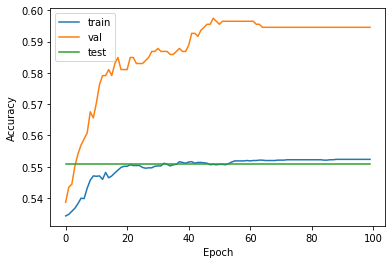

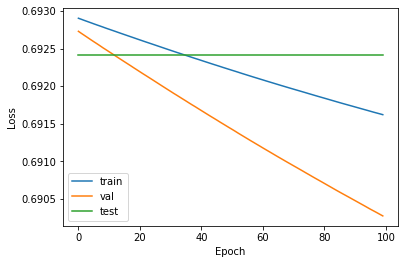

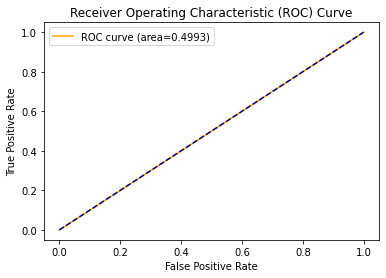

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       553
           1       0.33      0.00      0.00       449

    accuracy                           0.55      1002
   macro avg       0.44      0.50      0.36      1002
weighted avg       0.45      0.55      0.39      1002


Test Loss: 0.6924180016070307
Test Accuracy: 0.5508982
ROC-AUC Score: 0.499305267482088
Best model's epoch: 49


In [9]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-128-v2/fakenews-classifier-model-lstm-128-128.log")
model = load_model("model-weights/liarDataset/lstm-128-128-v2/fakenews-classifier-model-lstm-128-128-0049-0.597490.h5")

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 49)

## Modelos que no aprenden

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               142848    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,643,106
Trainable params: 1,643,106
Non-trainable params: 0
_________________________________________________________________
1267/1267 [==============================] - 1s 430us/sample - loss: 0.6519 - accuracy: 0.6251


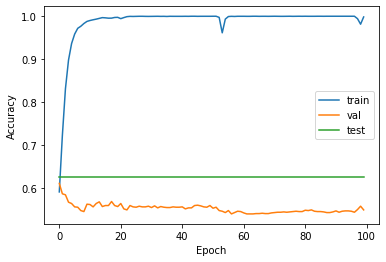

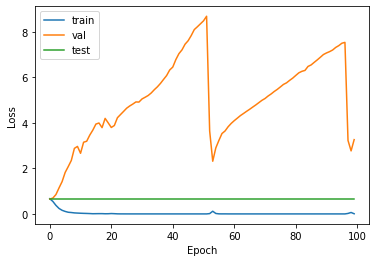

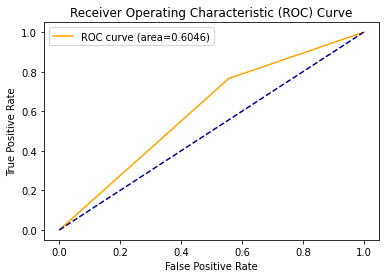

              precision    recall  f1-score   support

           0       0.59      0.44      0.51       553
           1       0.64      0.77      0.70       714

    accuracy                           0.63      1267
   macro avg       0.62      0.60      0.60      1267
weighted avg       0.62      0.63      0.61      1267


Test Loss: 0.6518547249386042
Test Accuracy: 0.62509865
ROC-AUC Score: 0.6045722086302876
Best model's epoch: 1


In [16]:
history = pd.read_csv("model-weights/liarDataset/lstm-128/fakenews-classifier-model-lstm-128-10000.log")
model = load_model("model-weights/liarDataset/lstm-128/fakenews-classifier-model-lstm-128-10000-0001-0.611371.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 1,917,282
Trainable params: 1,917,282
Non-trainable params: 0
_________________________________________________________________
1267/1267 [==============================] - 1s 532us/sample - loss: 0.7512 - accuracy: 0.5699


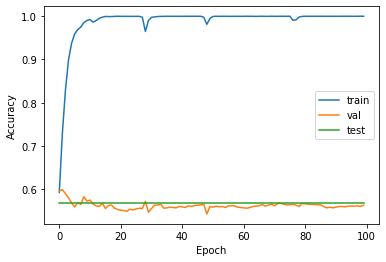

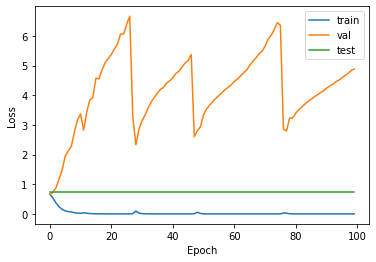

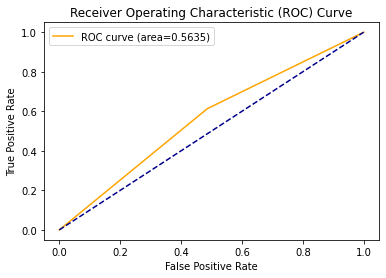

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       553
           1       0.62      0.61      0.62       714

    accuracy                           0.57      1267
   macro avg       0.56      0.56      0.56      1267
weighted avg       0.57      0.57      0.57      1267


Test Loss: 0.751211759323385
Test Accuracy: 0.56985
ROC-AUC Score: 0.5635038825656845
Best model's epoch: 2


In [17]:
history = pd.read_csv("model-weights/liarDataset/lstm-256/fakenews-classifier-model-lstm-256-10000.log")
model = load_model("model-weights/liarDataset/lstm-256/fakenews-classifier-model-lstm-256-10000-0002-0.599688.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1357824   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 2,858,850
Trainable params: 2,858,850
Non-trainable params: 0
_________________________________________________________________
1267/1267 [==============================] - 1s 761us/sample - loss: 0.6667 - accuracy: 0.6140


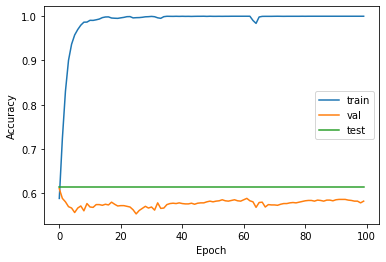

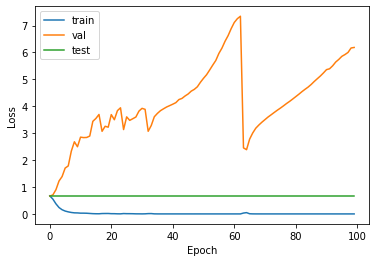

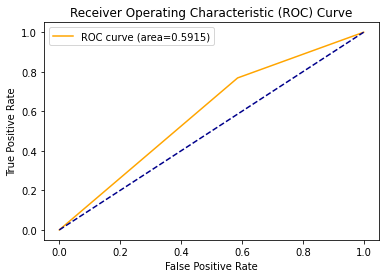

              precision    recall  f1-score   support

           0       0.58      0.41      0.48       553
           1       0.63      0.77      0.69       714

    accuracy                           0.61      1267
   macro avg       0.61      0.59      0.59      1267
weighted avg       0.61      0.61      0.60      1267


Test Loss: 0.6666772432372433
Test Accuracy: 0.61404896
ROC-AUC Score: 0.5915062227422614
Best model's epoch: 1


In [18]:
history = pd.read_csv("model-weights/liarDataset/lstm-512/fakenews-classifier-model-lstm-512-10000.log")
model = load_model("model-weights/liarDataset/lstm-512/fakenews-classifier-model-lstm-512-10000-0001-0.610592.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 128)           142848    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 1,692,386
Trainable params: 1,692,386
Non-trainable params: 0
_________________________________________________________________
1267/1267 [==============================] - 1s 826us/sample - loss: 0.6581 - accuracy: 0.6069


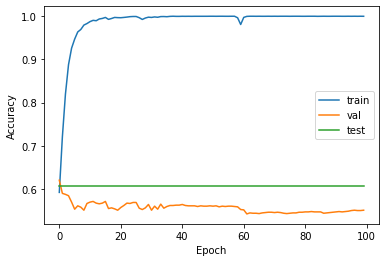

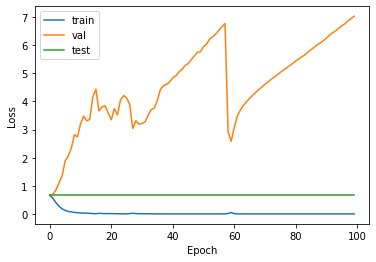

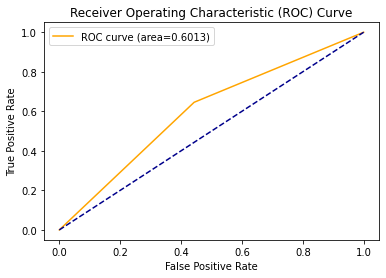

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       553
           1       0.65      0.65      0.65       714

    accuracy                           0.61      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.61      0.61      0.61      1267


Test Loss: 0.6581269440071359
Test Accuracy: 0.6069455
ROC-AUC Score: 0.6013101443108889
Best model's epoch: 1


In [19]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-64/fakenews-classifier-model-lstm-128-64-10000.log")
model = load_model("model-weights/liarDataset/lstm-128-64/fakenews-classifier-model-lstm-128-64-10000-0001-0.620717.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 64)            55040     
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)             

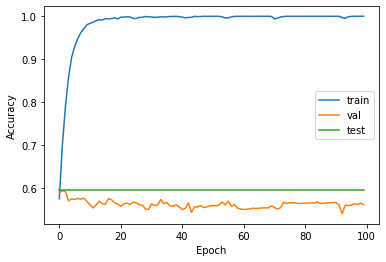

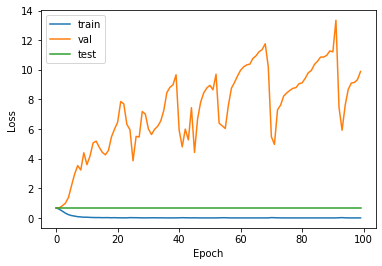

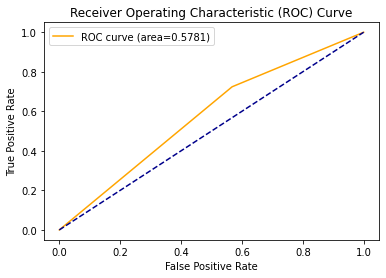

              precision    recall  f1-score   support

           0       0.55      0.43      0.48       553
           1       0.62      0.72      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.58      1267
weighted avg       0.59      0.60      0.59      1267


Test Loss: 0.6828344586616251
Test Accuracy: 0.5966851
ROC-AUC Score: 0.5781388504768996
Best model's epoch: 2


In [20]:
history = pd.read_csv("model-weights/liarDataset/lstm-64-128-dense-256-128/fakenews-classifier-model-lstm-64-128-dense-256-128-10000.log")
model = load_model("model-weights/liarDataset/lstm-64-128-dense-256-128/fakenews-classifier-model-lstm-64-128-dense-256-128-10000-0002-0.594237.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 64)            55040     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,608,866
Trainable params: 1,608,866
Non-trainable params: 0
____________________________________________

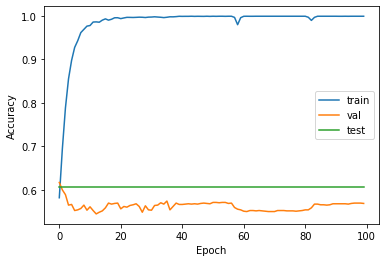

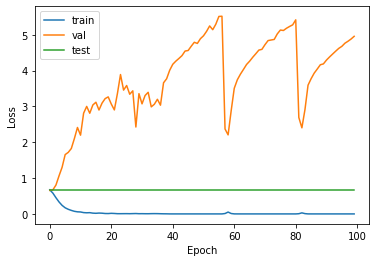

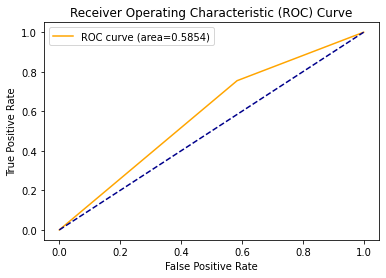

              precision    recall  f1-score   support

           0       0.57      0.42      0.48       553
           1       0.63      0.75      0.68       714

    accuracy                           0.61      1267
   macro avg       0.60      0.59      0.58      1267
weighted avg       0.60      0.61      0.60      1267


Test Loss: 0.6601295512119615
Test Accuracy: 0.6069455
ROC-AUC Score: 0.5854075807538205
Best model's epoch: 1


In [11]:
history = pd.read_csv("model-weights/liarDataset/lstm-64-64-32-32/fakenews-classifier-model-lstm-64-64-32-32-10000.log")
model = load_model("model-weights/liarDataset/lstm-64-64-32-32/fakenews-classifier-model-lstm-64-64-32-32-10000-0001-0.616822.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

### subSampled liar

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               142848    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,643,106
Trainable params: 1,643,106
Non-trainable params: 0
_________________________________________________________________
1281/1281 [==============================] - 0s 372us/sample - loss: 0.6499 - accuracy: 0.6190


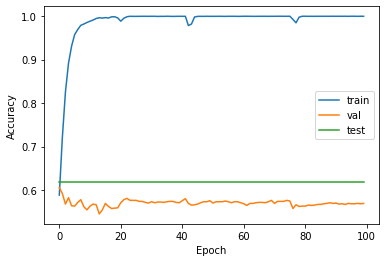

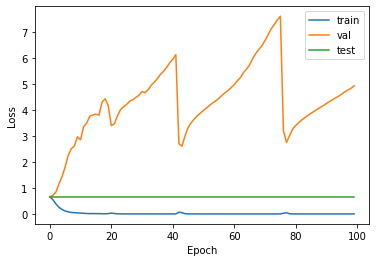

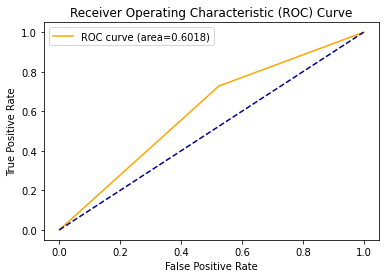

              precision    recall  f1-score   support

           0       0.57      0.48      0.52       553
           1       0.65      0.73      0.68       728

    accuracy                           0.62      1281
   macro avg       0.61      0.60      0.60      1281
weighted avg       0.61      0.62      0.61      1281


Test Loss: 0.6498640941326549
Test Accuracy: 0.61904764
ROC-AUC Score: 0.6018048407288914

              precision    recall  f1-score   support

           0       0.43      0.27      0.33       728
           1       0.35      0.52      0.42       553

    accuracy                           0.38      1281
   macro avg       0.39      0.40      0.38      1281
weighted avg       0.40      0.38      0.37      1281


Test Accuracy Combining samples: 0.38095238095238093
Best model's epoch: 1


In [59]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-subsamples/fakenews-classifier-model-lstm-128-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-128-subsamples/fakenews-classifier-model-lstm-128-subsamples-0001-0.605919.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 1,917,282
Trainable params: 1,917,282
Non-trainable params: 0
_________________________________________________________________
1281/1281 [==============================] - 0s 362us/sample - loss: 0.6554 - accuracy: 0.6230


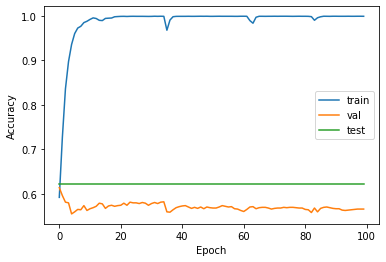

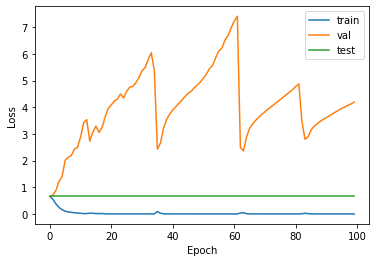

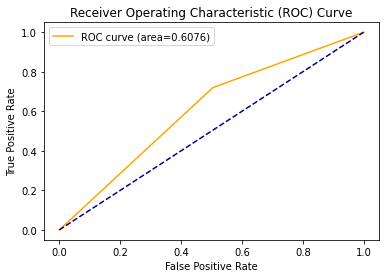

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       553
           1       0.65      0.72      0.68       728

    accuracy                           0.62      1281
   macro avg       0.61      0.61      0.61      1281
weighted avg       0.62      0.62      0.62      1281


Test Loss: 0.6553857842057501
Test Accuracy: 0.6229508
ROC-AUC Score: 0.6076297120600919

              precision    recall  f1-score   support

           0       0.43      0.28      0.34       728
           1       0.35      0.50      0.41       553

    accuracy                           0.38      1281
   macro avg       0.39      0.39      0.37      1281
weighted avg       0.39      0.38      0.37      1281


Test Accuracy Combining samples: 0.3770491803278688
Best model's epoch: 1


In [60]:
history = pd.read_csv("model-weights/liarDataset/lstm-256-subsamples/fakenews-classifier-model-lstm-256-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-256-subsamples/fakenews-classifier-model-lstm-256-subsamples-0001-0.613707.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1357824   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 2,858,850
Trainable params: 2,858,850
Non-trainable params: 0
_________________________________________________________________
1281/1281 [==============================] - 1s 542us/sample - loss: 0.6627 - accuracy: 0.6081


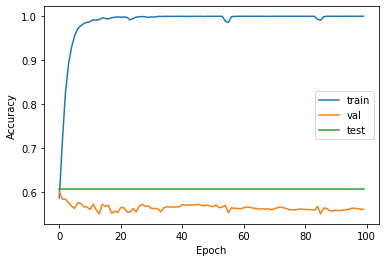

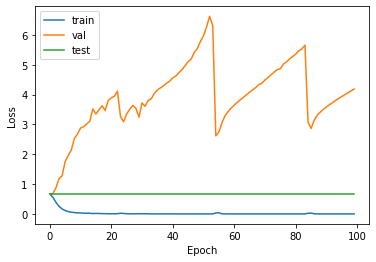

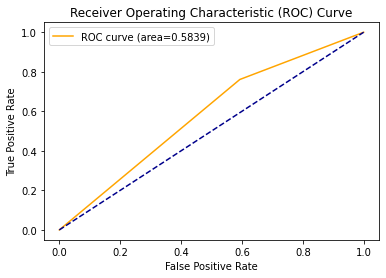

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       553
           1       0.63      0.76      0.69       728

    accuracy                           0.61      1281
   macro avg       0.60      0.58      0.58      1281
weighted avg       0.60      0.61      0.60      1281


Test Loss: 0.6626685706085753
Test Accuracy: 0.60811865
ROC-AUC Score: 0.583930310196133

              precision    recall  f1-score   support

           0       0.44      0.24      0.31       728
           1       0.37      0.59      0.46       553

    accuracy                           0.39      1281
   macro avg       0.40      0.42      0.38      1281
weighted avg       0.41      0.39      0.37      1281


Test Accuracy Combining samples: 0.3918813427010148
Best model's epoch: 1


In [61]:
history = pd.read_csv("model-weights/liarDataset/lstm-512-subsamples/fakenews-classifier-model-lstm-512-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-512-subsamples/fakenews-classifier-model-lstm-512-subsamples-0001-0.601246.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           142848    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 1,692,386
Trainable params: 1,692,386
Non-trainable params: 0
_________________________________________________________________
1281/1281 [==============================] - 1s 513us/sample - loss: 0.6526 - accuracy: 0.6300


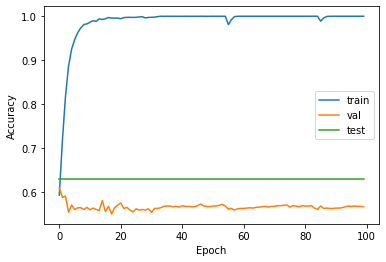

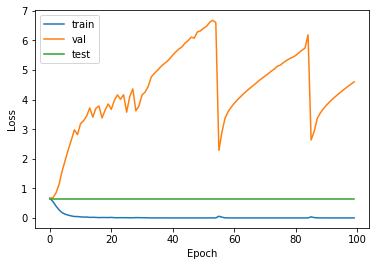

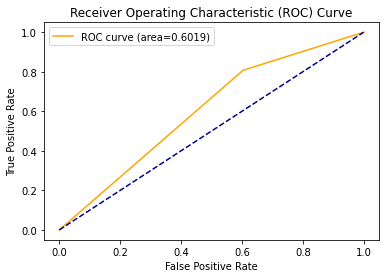

              precision    recall  f1-score   support

           0       0.61      0.40      0.48       553
           1       0.64      0.81      0.71       728

    accuracy                           0.63      1281
   macro avg       0.62      0.60      0.60      1281
weighted avg       0.63      0.63      0.61      1281


Test Loss: 0.6525909582401607
Test Accuracy: 0.6299766
ROC-AUC Score: 0.6018570037557379

              precision    recall  f1-score   support

           0       0.39      0.19      0.26       728
           1       0.36      0.60      0.45       553

    accuracy                           0.37      1281
   macro avg       0.38      0.40      0.36      1281
weighted avg       0.38      0.37      0.34      1281


Test Accuracy Combining samples: 0.3700234192037471
Best model's epoch: 1


In [62]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-64-subsamples/fakenews-classifier-model-lstm-128-64-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-128-64-subsamples/fakenews-classifier-model-lstm-128-64-subsamples-0001-0.609813.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 64)            55040     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 32)            12416     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,608,866
Trainable params: 1,608,866
Non-trainable params: 0
____________________________________________

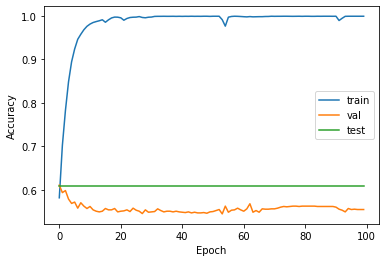

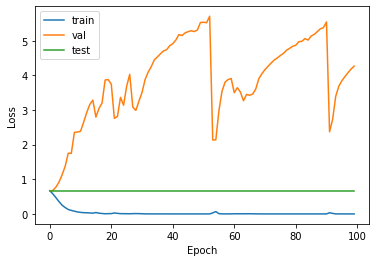

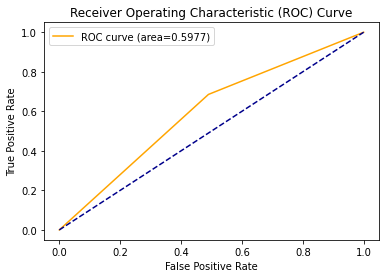

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       553
           1       0.65      0.69      0.67       728

    accuracy                           0.61      1281
   macro avg       0.60      0.60      0.60      1281
weighted avg       0.61      0.61      0.61      1281


Test Loss: 0.6603831531106262
Test Accuracy: 0.60967994
ROC-AUC Score: 0.59769265544582

              precision    recall  f1-score   support

           0       0.45      0.31      0.37       728
           1       0.35      0.49      0.41       553

    accuracy                           0.39      1281
   macro avg       0.40      0.40      0.39      1281
weighted avg       0.41      0.39      0.39      1281


Test Accuracy Combining samples: 0.39032006245121
Best model's epoch: 1


In [63]:
history = pd.read_csv("model-weights/liarDataset/lstm-64-64-32-32-subsamples/fakenews-classifier-model-lstm-64-64-32-32-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-64-64-32-32-subsamples/fakenews-classifier-model-lstm-64-64-32-32-subsamples-0001-0.610592.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 150)           1500000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 64)            55040     
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

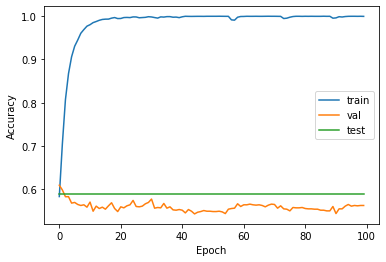

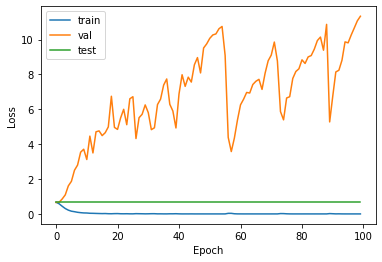

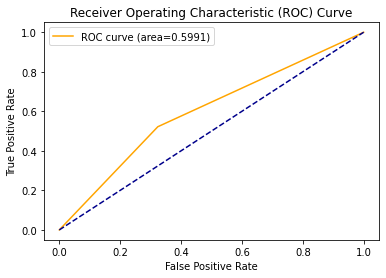

              precision    recall  f1-score   support

           0       0.52      0.68      0.59       553
           1       0.68      0.52      0.59       728

    accuracy                           0.59      1281
   macro avg       0.60      0.60      0.59      1281
weighted avg       0.61      0.59      0.59      1281


Test Loss: 0.6627222468944195
Test Accuracy: 0.58860266
ROC-AUC Score: 0.5991445263597162

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       728
           1       0.32      0.32      0.32       553

    accuracy                           0.41      1281
   macro avg       0.40      0.40      0.40      1281
weighted avg       0.41      0.41      0.41      1281


Test Accuracy Combining samples: 0.41139734582357534
Best model's epoch: 1


In [64]:
history = pd.read_csv("model-weights/liarDataset/lstm-64-128-dense-256-128-subsamples/fakenews-classifier-model-lstm-64-128-dense-256-128-subsamples.log")
model = load_model("model-weights/liarDataset/lstm-64-128-dense-256-128-subsamples/fakenews-classifier-model-lstm-64-128-dense-256-128-subsamples-0001-0.609813.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history, subsamples=True)

print("Best model's epoch:", 1)

## Model Testing

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-32-32-64-64', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 32)            23424     
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 64)            24832     
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 130       
Total params: 1,589,730
Trainable params: 1,589,730
Non-trainable params: 0
___________________________________________

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 97s 9ms/step - loss: 0.6715 - accuracy: 0.5835 - val_loss: 0.6648 - val_accuracy: 0.6044

Epoch 00001: val_accuracy improved from -inf to 0.60436, saving model to fakenews-classifier-model-lstm-32-32-64-64-0001-0.604361.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 2/100
10240/10240 [==============================] - 93s 9ms/step - loss: 0.5774 - accuracy: 0.7003 - val_loss: 0.7027 - val_accuracy: 0.6090

Epoch 00002: val_accuracy improved from 0.60436 to 0.60903, saving model to fakenews-classifier-model-lstm-32-32-64-64-0002-0.609034.h5

Epoch 00002: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 3/100
10240/10240 [==============================] - 93s 9ms/step - loss: 0.4534 - accuracy: 0.7918 - val_loss: 0.8019 - val_accuracy: 0.5654

Epoch 00003: val_accuracy did not improve from 0.60903

Epoch 00003: saving model t


Epoch 00029: val_accuracy did not improve from 0.60903

Epoch 00029: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 30/100
10240/10240 [==============================] - 91s 9ms/step - loss: 0.0022 - accuracy: 0.9990 - val_loss: 4.3148 - val_accuracy: 0.5584

Epoch 00030: val_accuracy did not improve from 0.60903

Epoch 00030: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 31/100
10240/10240 [==============================] - 95s 9ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 4.4735 - val_accuracy: 0.5514

Epoch 00031: val_accuracy did not improve from 0.60903

Epoch 00031: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 32/100
10240/10240 [==============================] - 91s 9ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 4.4595 - val_accuracy: 0.5545

Epoch 00032: val_accuracy did not improve from 0.60903

Epoch 00032: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 33/100
10240/10240 


Epoch 00058: val_accuracy did not improve from 0.60903

Epoch 00058: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 59/100
10240/10240 [==============================] - 97s 10ms/step - loss: 7.6930e-04 - accuracy: 0.9994 - val_loss: 5.9572 - val_accuracy: 0.5584

Epoch 00059: val_accuracy did not improve from 0.60903

Epoch 00059: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 60/100
10240/10240 [==============================] - 96s 9ms/step - loss: 8.5122e-04 - accuracy: 0.9995 - val_loss: 5.4040 - val_accuracy: 0.5537

Epoch 00060: val_accuracy did not improve from 0.60903

Epoch 00060: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 61/100
10240/10240 [==============================] - 93s 9ms/step - loss: 7.6585e-04 - accuracy: 0.9995 - val_loss: 6.0000 - val_accuracy: 0.5584

Epoch 00061: val_accuracy did not improve from 0.60903

Epoch 00061: saving model to fakenews-classifier-model-lstm-32-32-64-64.h5
Epoch 62/100

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 32)            23424     
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 64)            24832     
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 130       
Total params: 1,589,730
Trainable params: 1,589,730
Non-trainable params: 0
___________________________________________

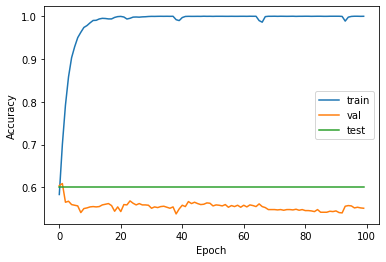

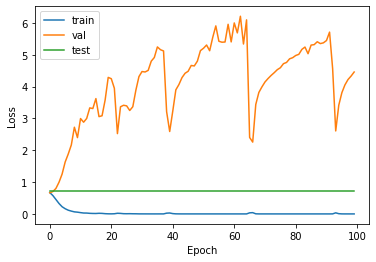

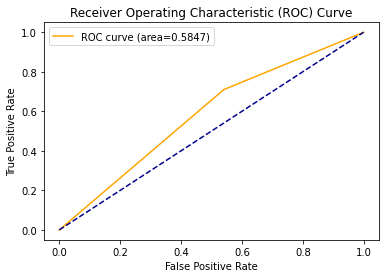

              precision    recall  f1-score   support

           0       0.55      0.46      0.50       553
           1       0.63      0.71      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.58      1267
weighted avg       0.59      0.60      0.59      1267


Test Loss: 0.7133545688314521
Test Accuracy: 0.6006314
ROC-AUC Score: 0.5846984363365599
Best model's epoch: 2


In [5]:
history = pd.read_csv("model-weights/liarDataset/lstm-32-32-64-64/fakenews-classifier-model-lstm-32-32-64-64.log")
model = load_model("model-weights/liarDataset/lstm-32-32-64-64/fakenews-classifier-model-lstm-32-32-64-64-0002-0.609034.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 2)

In [27]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True, mask_zero=True))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-64-128', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 64)            55040     
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 1,654,114
Trainable params: 1,654,114
Non-trainable params: 0
_________________________________________________________________


/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.6672 - accuracy: 0.5947 - val_loss: 0.6571 - val_accuracy: 0.6098

Epoch 00001: val_accuracy improved from -inf to 0.60981, saving model to fakenews-classifier-model-lstm-64-128-0001-0.609813.h5

Epoch 00001: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 2/100
10240/10240 [==============================] - 45s 4ms/step - loss: 0.5633 - accuracy: 0.7132 - val_loss: 0.6888 - val_accuracy: 0.5849

Epoch 00002: val_accuracy did not improve from 0.60981

Epoch 00002: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 3/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.4147 - accuracy: 0.8055 - val_loss: 0.8354 - val_accuracy: 0.5841

Epoch 00003: val_accuracy did not improve from 0.60981

Epoch 00003: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 4/100
10240/10240 [============================


Epoch 00059: val_accuracy did not improve from 0.60981

Epoch 00059: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 60/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 3.2224 - val_accuracy: 0.5506

Epoch 00060: val_accuracy did not improve from 0.60981

Epoch 00060: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 61/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 3.6121 - val_accuracy: 0.5537

Epoch 00061: val_accuracy did not improve from 0.60981

Epoch 00061: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 62/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 3.9372 - val_accuracy: 0.5600

Epoch 00062: val_accuracy did not improve from 0.60981

Epoch 00062: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 63/100
10240/10240 [===================

10240/10240 [==============================] - 44s 4ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 3.2262 - val_accuracy: 0.5623

Epoch 00089: val_accuracy did not improve from 0.60981

Epoch 00089: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 90/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 3.5283 - val_accuracy: 0.5631

Epoch 00090: val_accuracy did not improve from 0.60981

Epoch 00090: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 91/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0010 - accuracy: 0.9994 - val_loss: 3.7860 - val_accuracy: 0.5639

Epoch 00091: val_accuracy did not improve from 0.60981

Epoch 00091: saving model to fakenews-classifier-model-lstm-64-128.h5
Epoch 92/100
10240/10240 [==============================] - 44s 4ms/step - loss: 8.1201e-04 - accuracy: 0.9995 - val_loss: 4.0257 - val_accuracy: 0.5631

Epoch 00092: val_accuracy did n

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 64)            55040     
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 1,654,114
Trainable params: 1,654,114
Non-trainable params: 0
_________________________________________________________________
1267/1267 [==============================] - 2s 1ms/sample - loss: 0.6582 - accuracy: 0.6164


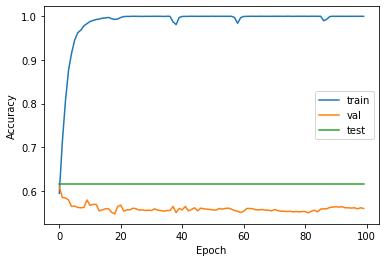

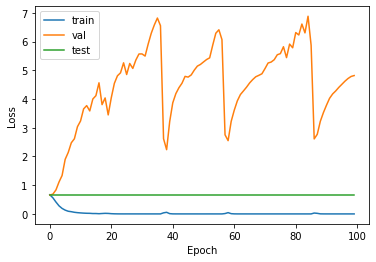

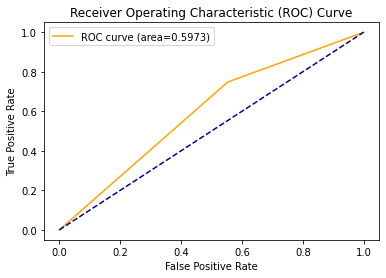

              precision    recall  f1-score   support

           0       0.58      0.45      0.50       553
           1       0.64      0.75      0.69       714

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.61      0.62      0.61      1267


Test Loss: 0.6582464009829178
Test Accuracy: 0.61641675
ROC-AUC Score: 0.5972768854377194
Best model's epoch: 1


In [6]:
history = pd.read_csv("model-weights/liarDataset/lstm-64-128/fakenews-classifier-model-lstm-64-128.log")
model = load_model("model-weights/liarDataset/lstm-64-128/fakenews-classifier-model-lstm-64-128-0001-0.609813.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))
model.add(Conv1D(filters=128, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'conv-128-lstm-128', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 46, 128)           96128     
_________________________________________________________________
batch_normalization_23 (Batc (None, 46, 128)           512       
_________________________________________________________________
activation_19 (Activation)   (None, 46, 128)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 23, 128)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 2)               

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 14s 1ms/step - loss: 0.6831 - accuracy: 0.5593 - val_loss: 0.6683 - val_accuracy: 0.6075

Epoch 00001: val_accuracy improved from -inf to 0.60748, saving model to fakenews-classifier-model-conv-128-lstm-128-0001-0.607477.h5

Epoch 00001: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 2/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.6044 - accuracy: 0.6851 - val_loss: 0.7060 - val_accuracy: 0.5210

Epoch 00002: val_accuracy did not improve from 0.60748

Epoch 00002: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 3/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.4613 - accuracy: 0.7964 - val_loss: 0.7902 - val_accuracy: 0.5826

Epoch 00003: val_accuracy did not improve from 0.60748

Epoch 00003: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 4/100
10240/10240 [====

10240/10240 [==============================] - 10s 1ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 1.8698 - val_accuracy: 0.5553

Epoch 00030: val_accuracy did not improve from 0.60748

Epoch 00030: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 31/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 2.2433 - val_accuracy: 0.5646

Epoch 00031: val_accuracy did not improve from 0.60748

Epoch 00031: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 32/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 2.2838 - val_accuracy: 0.5678

Epoch 00032: val_accuracy did not improve from 0.60748

Epoch 00032: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 33/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 3.3476 - val_accuracy: 0.5693

Epoch 00033: val_

10240/10240 [==============================] - 10s 1ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 2.3206 - val_accuracy: 0.5615

Epoch 00059: val_accuracy did not improve from 0.60748

Epoch 00059: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 60/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 2.9513 - val_accuracy: 0.5646

Epoch 00060: val_accuracy did not improve from 0.60748

Epoch 00060: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 61/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 3.0867 - val_accuracy: 0.5631

Epoch 00061: val_accuracy did not improve from 0.60748

Epoch 00061: saving model to fakenews-classifier-model-conv-128-lstm-128.h5
Epoch 62/100
10240/10240 [==============================] - 10s 1ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 3.5150 - val_accuracy: 0.5623

Epoch 00062: val_

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 46, 128)           96128     
_________________________________________________________________
batch_normalization_23 (Batc (None, 46, 128)           512       
_________________________________________________________________
activation_19 (Activation)   (None, 46, 128)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 23, 128)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 2)               

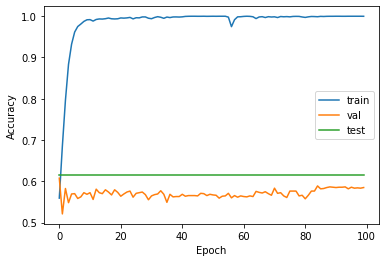

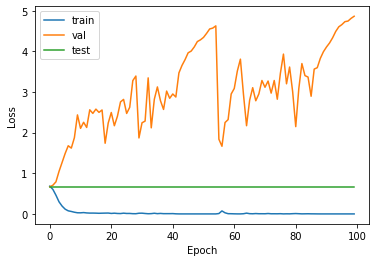

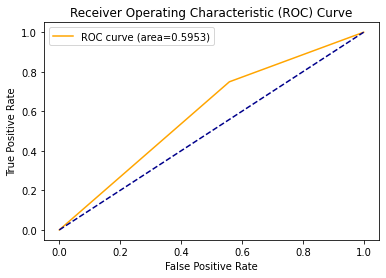

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       553
           1       0.63      0.75      0.69       714

    accuracy                           0.61      1267
   macro avg       0.61      0.60      0.59      1267
weighted avg       0.61      0.61      0.61      1267


Test Loss: 0.6587253430271676
Test Accuracy: 0.6148382
ROC-AUC Score: 0.5952646881537424
Best model's epoch: 1


In [7]:
history = pd.read_csv("model-weights/liarDataset/conv-128-lstm-128/fakenews-classifier-model-conv-128-lstm-128.log")
model = load_model("model-weights/liarDataset/conv-128-lstm-128/fakenews-classifier-model-conv-128-lstm-128-0001-0.607477.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 1)

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Conv1D(filters=64, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'conv-64-64-lstm-256', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 46, 64)            48064     
_________________________________________________________________
batch_normalization_28 (Batc (None, 46, 64)            256       
_________________________________________________________________
activation_23 (Activation)   (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 19, 64)            20544     
_________________________________________________________________
batch_normalization_29 (Batc (None, 19, 64)          

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 5s 518us/step - loss: 0.7253 - accuracy: 0.5513 - val_loss: 0.7365 - val_accuracy: 0.4798

Epoch 00001: val_accuracy improved from -inf to 0.47975, saving model to fakenews-classifier-model-conv-64-64-lstm-256-0001-0.479751.h5

Epoch 00001: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 2/100
10240/10240 [==============================] - 4s 378us/step - loss: 0.4941 - accuracy: 0.7568 - val_loss: 0.8275 - val_accuracy: 0.5600

Epoch 00002: val_accuracy improved from 0.47975 to 0.55997, saving model to fakenews-classifier-model-conv-64-64-lstm-256-0002-0.559969.h5

Epoch 00002: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 3/100
10240/10240 [==============================] - 4s 419us/step - loss: 0.1947 - accuracy: 0.9230 - val_loss: 1.2371 - val_accuracy: 0.5522

Epoch 00003: val_accuracy did not improve from 0.55997

Epoch 00003:

Epoch 28/100
10240/10240 [==============================] - 5s 451us/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 1.9824 - val_accuracy: 0.5794

Epoch 00028: val_accuracy did not improve from 0.59190

Epoch 00028: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 29/100
10240/10240 [==============================] - 5s 448us/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 2.1411 - val_accuracy: 0.5794

Epoch 00029: val_accuracy did not improve from 0.59190

Epoch 00029: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 30/100
10240/10240 [==============================] - 5s 448us/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 2.0795 - val_accuracy: 0.5857

Epoch 00030: val_accuracy did not improve from 0.59190

Epoch 00030: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 31/100
10240/10240 [==============================] - 5s 448us/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 2.1400 - val_accuracy: 0.

Epoch 57/100
10240/10240 [==============================] - 5s 449us/step - loss: 0.0160 - accuracy: 0.9942 - val_loss: 2.5391 - val_accuracy: 0.5903

Epoch 00057: val_accuracy did not improve from 0.59190

Epoch 00057: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 58/100
10240/10240 [==============================] - 5s 449us/step - loss: 0.0195 - accuracy: 0.9930 - val_loss: 2.3909 - val_accuracy: 0.5810

Epoch 00058: val_accuracy did not improve from 0.59190

Epoch 00058: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 59/100
10240/10240 [==============================] - 5s 447us/step - loss: 0.0159 - accuracy: 0.9941 - val_loss: 2.2634 - val_accuracy: 0.5826

Epoch 00059: val_accuracy did not improve from 0.59190

Epoch 00059: saving model to fakenews-classifier-model-conv-64-64-lstm-256.h5
Epoch 60/100
10240/10240 [==============================] - 5s 448us/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 2.4584 - val_accuracy: 0.

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 46, 64)            48064     
_________________________________________________________________
batch_normalization_28 (Batc (None, 46, 64)            256       
_________________________________________________________________
activation_23 (Activation)   (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 19, 64)            20544     
_________________________________________________________________
batch_normalization_29 (Batc (None, 19, 64)          

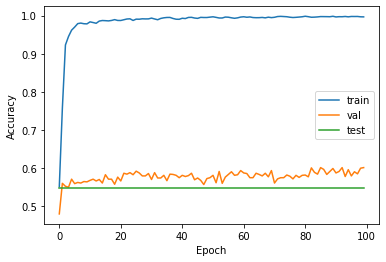

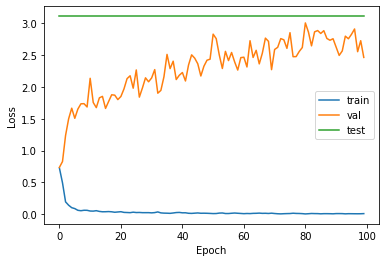

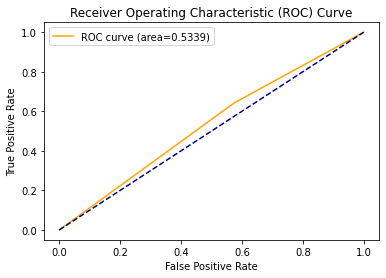

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       553
           1       0.59      0.64      0.62       714

    accuracy                           0.55      1267
   macro avg       0.54      0.53      0.53      1267
weighted avg       0.54      0.55      0.54      1267


Test Loss: 3.1079872089196305
Test Accuracy: 0.5477506
ROC-AUC Score: 0.5339059674502712
Best model's epoch: 86


In [9]:
history = pd.read_csv("model-weights/liarDataset/conv-64-64-lstm-256/fakenews-classifier-model-conv-64-64-lstm-256.log")
model = load_model("model-weights/liarDataset/conv-64-64-lstm-256/fakenews-classifier-model-conv-64-64-lstm-256-0086-0.601246.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 86)

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Conv1D(filters=32, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=5, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(LSTM(128))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'conv-32-64-lstm-128-dense-128-64', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 46, 32)            24032     
_________________________________________________________________
batch_normalization_31 (Batc (None, 46, 32)            128       
_________________________________________________________________
activation_25 (Activation)   (None, 46, 32)            0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 19, 64)            10304     
_________________________________________________________________
batch_normalization_32 (Batc (None, 19, 64)          

/home/david/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 9s 907us/step - loss: 0.6942 - accuracy: 0.5520 - val_loss: 0.6907 - val_accuracy: 0.5319

Epoch 00001: val_accuracy improved from -inf to 0.53193, saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64-0001-0.531931.h5

Epoch 00001: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 2/100
10240/10240 [==============================] - 8s 739us/step - loss: 0.5726 - accuracy: 0.7028 - val_loss: 0.6746 - val_accuracy: 0.5779

Epoch 00002: val_accuracy improved from 0.53193 to 0.57788, saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64-0002-0.577882.h5

Epoch 00002: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 3/100
10240/10240 [==============================] - 8s 741us/step - loss: 0.2880 - accuracy: 0.8803 - val_loss: 1.2220 - val_accuracy: 0.5475

Epoch 00003: val


Epoch 00026: val_accuracy did not improve from 0.59579

Epoch 00026: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 27/100
10240/10240 [==============================] - 8s 737us/step - loss: 0.0216 - accuracy: 0.9934 - val_loss: 2.3502 - val_accuracy: 0.5849

Epoch 00027: val_accuracy did not improve from 0.59579

Epoch 00027: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 28/100
10240/10240 [==============================] - 8s 736us/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 2.2201 - val_accuracy: 0.5693

Epoch 00028: val_accuracy did not improve from 0.59579

Epoch 00028: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 29/100
10240/10240 [==============================] - 8s 736us/step - loss: 0.0205 - accuracy: 0.9920 - val_loss: 2.6180 - val_accuracy: 0.5841

Epoch 00029: val_accuracy did not improve from 0.59579

Epoch 00029: saving model to fakenews-classifier-

10240/10240 [==============================] - 8s 738us/step - loss: 0.0145 - accuracy: 0.9964 - val_loss: 2.6352 - val_accuracy: 0.6005

Epoch 00054: val_accuracy did not improve from 0.60125

Epoch 00054: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 55/100
10240/10240 [==============================] - 8s 735us/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 3.2625 - val_accuracy: 0.5748

Epoch 00055: val_accuracy did not improve from 0.60125

Epoch 00055: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 56/100
10240/10240 [==============================] - 8s 737us/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 2.5980 - val_accuracy: 0.5888

Epoch 00056: val_accuracy did not improve from 0.60125

Epoch 00056: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 57/100
10240/10240 [==============================] - 8s 737us/step - loss: 0.0142 - accuracy: 0.9958 - val_loss:

10240/10240 [==============================] - 8s 738us/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 3.0451 - val_accuracy: 0.5857

Epoch 00082: val_accuracy did not improve from 0.60125

Epoch 00082: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 83/100
10240/10240 [==============================] - 8s 736us/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 3.2800 - val_accuracy: 0.5810

Epoch 00083: val_accuracy did not improve from 0.60125

Epoch 00083: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 84/100
10240/10240 [==============================] - 8s 739us/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 3.0421 - val_accuracy: 0.5896

Epoch 00084: val_accuracy did not improve from 0.60125

Epoch 00084: saving model to fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.h5
Epoch 85/100
10240/10240 [==============================] - 8s 736us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss:

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 150)           1500000   
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 46, 32)            24032     
_________________________________________________________________
batch_normalization_31 (Batc (None, 46, 32)            128       
_________________________________________________________________
activation_25 (Activation)   (None, 46, 32)            0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 23, 32)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 19, 64)            10304     
_________________________________________________________________
batch_normalization_32 (Batc (None, 19, 64)          

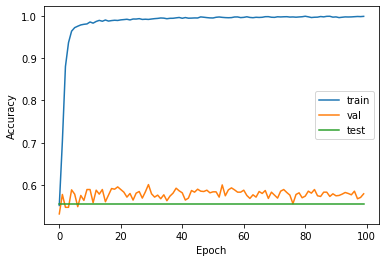

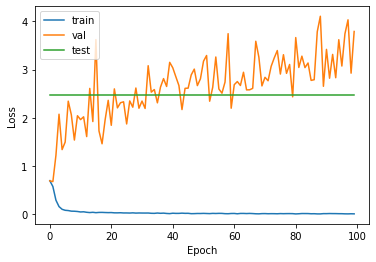

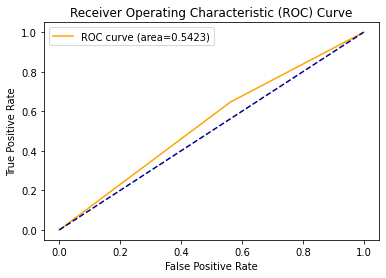

              precision    recall  f1-score   support

           0       0.49      0.44      0.46       553
           1       0.60      0.65      0.62       714

    accuracy                           0.56      1267
   macro avg       0.54      0.54      0.54      1267
weighted avg       0.55      0.56      0.55      1267


Test Loss: 2.474918679920067
Test Accuracy: 0.55564326
ROC-AUC Score: 0.5423359217104563
Best model's epoch: 30


In [11]:
history = pd.read_csv("model-weights/liarDataset/conv-32-64-lstm-128-dense-128-64/fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64.log")
model = load_model("model-weights/liarDataset/conv-32-64-lstm-128-dense-128-64/fakenews-classifier-model-conv-32-64-lstm-128-dense-128-64-0030-0.601246.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 30)

## Pruebas Glove

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix_liar_news], input_length=max_length, trainable=False, mask_zero=True))
model.add(LSTM(512, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-512_glove', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               1255424   
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total params: 2,256,450
Trainable params: 1,256,450
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 30s 3ms/step - loss: 0.6752 - accuracy: 0.5797 - val_loss: 0.6757 - val_accuracy: 0.5826

Epoch 00001: val_accuracy improved from -inf to 0.58255, saving model to fakenews-classifier-model-lstm-512_glove-0001-0.582555.h5

Epoch 00001: saving model to fakene

10240/10240 [==============================] - 28s 3ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 2.5352 - val_accuracy: 0.5833

Epoch 00027: val_accuracy did not improve from 0.61215

Epoch 00027: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 28/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 2.6155 - val_accuracy: 0.5810

Epoch 00028: val_accuracy did not improve from 0.61215

Epoch 00028: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 29/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 2.6143 - val_accuracy: 0.5903

Epoch 00029: val_accuracy did not improve from 0.61215

Epoch 00029: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 30/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 2.6560 - val_accuracy: 0.5919

Epoch 00030: val_accuracy 


Epoch 00056: val_accuracy did not improve from 0.61215

Epoch 00056: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 57/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0012 - accuracy: 0.9992 - val_loss: 3.4984 - val_accuracy: 0.5724

Epoch 00057: val_accuracy did not improve from 0.61215

Epoch 00057: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 58/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 3.6152 - val_accuracy: 0.5678

Epoch 00058: val_accuracy did not improve from 0.61215

Epoch 00058: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 59/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.0010 - accuracy: 0.9994 - val_loss: 3.6104 - val_accuracy: 0.5670

Epoch 00059: val_accuracy did not improve from 0.61215

Epoch 00059: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 60/100
10240/10240 [=======

10240/10240 [==============================] - 28s 3ms/step - loss: 8.5977e-04 - accuracy: 0.9994 - val_loss: 3.6762 - val_accuracy: 0.5771

Epoch 00086: val_accuracy did not improve from 0.61215

Epoch 00086: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 87/100
10240/10240 [==============================] - 28s 3ms/step - loss: 8.5111e-04 - accuracy: 0.9995 - val_loss: 3.7426 - val_accuracy: 0.5732

Epoch 00087: val_accuracy did not improve from 0.61215

Epoch 00087: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 88/100
10240/10240 [==============================] - 28s 3ms/step - loss: 9.5895e-04 - accuracy: 0.9995 - val_loss: 3.7046 - val_accuracy: 0.5779

Epoch 00088: val_accuracy did not improve from 0.61215

Epoch 00088: saving model to fakenews-classifier-model-lstm-512_glove.h5
Epoch 89/100
10240/10240 [==============================] - 28s 3ms/step - loss: 0.1298 - accuracy: 0.9532 - val_loss: 2.0578 - val_accuracy: 0.5662

Epoch 00089: v

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               1255424   
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total params: 2,256,450
Trainable params: 1,256,450
Non-trainable params: 1,000,000
_________________________________________________________________
1267/1267 [==============================] - 1s 915us/sample - loss: 0.6686 - accuracy: 0.6093


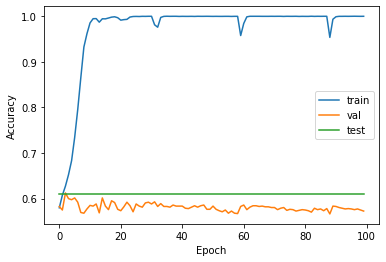

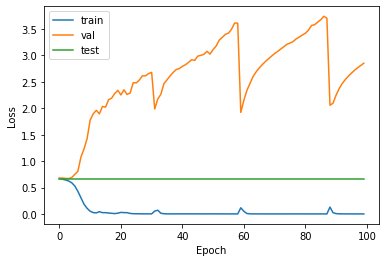

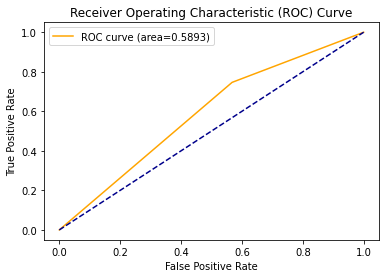

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       553
           1       0.63      0.75      0.68       714

    accuracy                           0.61      1267
   macro avg       0.60      0.59      0.59      1267
weighted avg       0.60      0.61      0.60      1267


Test Loss: 0.6686324623972766
Test Accuracy: 0.6093133
ROC-AUC Score: 0.5893433322696167
Best model's epoch: 3


In [12]:
history = pd.read_csv("model-weights/liarDataset/lstm-512_glove/fakenews-classifier-model-lstm-512_glove.log")
model = load_model("model-weights/liarDataset/lstm-512_glove/fakenews-classifier-model-lstm-512_glove-0003-0.612150.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 3)

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix_liar_news], input_length=max_length, trainable=False, mask_zero=True))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-256_glove', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 1,366,082
Trainable params: 366,082
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.6746 - accuracy: 0.5801 - val_loss: 0.6693 - val_accuracy: 0.5974

Epoch 00001: val_accuracy improved from -inf to 0.59735, saving model to fakenews-classifier-model-lstm-256_glove-0001-0.597352.h5

Epoch 00001: saving model to fakenews

10240/10240 [==============================] - 22s 2ms/step - loss: 0.0415 - accuracy: 0.9864 - val_loss: 1.9691 - val_accuracy: 0.5818

Epoch 00027: val_accuracy did not improve from 0.60981

Epoch 00027: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 28/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 2.1588 - val_accuracy: 0.5826

Epoch 00028: val_accuracy did not improve from 0.60981

Epoch 00028: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 29/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 2.1620 - val_accuracy: 0.5997

Epoch 00029: val_accuracy did not improve from 0.60981

Epoch 00029: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 30/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0150 - accuracy: 0.9965 - val_loss: 2.1055 - val_accuracy: 0.5872

Epoch 00030: val_accuracy 


Epoch 00056: val_accuracy did not improve from 0.60981

Epoch 00056: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 57/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0018 - accuracy: 0.9991 - val_loss: 3.2039 - val_accuracy: 0.5950

Epoch 00057: val_accuracy did not improve from 0.60981

Epoch 00057: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 58/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0014 - accuracy: 0.9993 - val_loss: 3.2684 - val_accuracy: 0.5950

Epoch 00058: val_accuracy did not improve from 0.60981

Epoch 00058: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 59/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 3.2247 - val_accuracy: 0.6005

Epoch 00059: val_accuracy did not improve from 0.60981

Epoch 00059: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 60/100
10240/10240 [=======

10240/10240 [==============================] - 22s 2ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 3.6121 - val_accuracy: 0.5787

Epoch 00086: val_accuracy did not improve from 0.60981

Epoch 00086: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 87/100
10240/10240 [==============================] - 22s 2ms/step - loss: 9.9933e-04 - accuracy: 0.9994 - val_loss: 3.7015 - val_accuracy: 0.5794

Epoch 00087: val_accuracy did not improve from 0.60981

Epoch 00087: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 88/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0010 - accuracy: 0.9993 - val_loss: 3.6673 - val_accuracy: 0.5779

Epoch 00088: val_accuracy did not improve from 0.60981

Epoch 00088: saving model to fakenews-classifier-model-lstm-256_glove.h5
Epoch 89/100
10240/10240 [==============================] - 22s 2ms/step - loss: 9.9674e-04 - accuracy: 0.9996 - val_loss: 3.8116 - val_accuracy: 0.5693

Epoch 00089: val_a

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               365568    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 1,366,082
Trainable params: 366,082
Non-trainable params: 1,000,000
_________________________________________________________________
1267/1267 [==============================] - 1s 759us/sample - loss: 1.8431 - accuracy: 0.5841


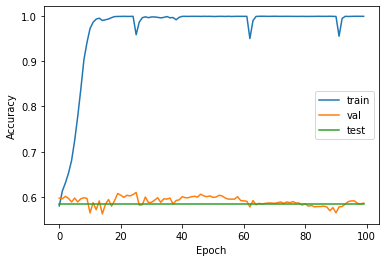

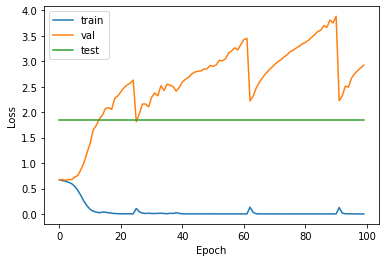

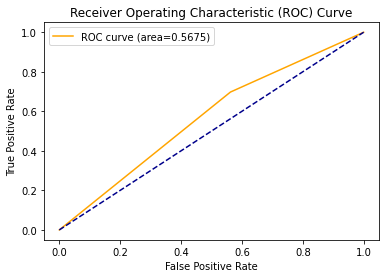

              precision    recall  f1-score   support

           0       0.53      0.44      0.48       553
           1       0.62      0.70      0.65       714

    accuracy                           0.58      1267
   macro avg       0.57      0.57      0.57      1267
weighted avg       0.58      0.58      0.58      1267


Test Loss: 1.8430844519960663
Test Accuracy: 0.58405685
ROC-AUC Score: 0.5675460057440698
Best model's epoch: 26


In [13]:
history = pd.read_csv("model-weights/liarDataset/lstm-256_glove/fakenews-classifier-model-lstm-256_glove.log")
model = load_model("model-weights/liarDataset/lstm-256_glove/fakenews-classifier-model-lstm-256_glove-0026-0.609813.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 26)

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix_liar_news], input_length=max_length, trainable=False, mask_zero=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-128_glove', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 1,117,506
Trainable params: 117,506
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.6731 - accuracy: 0.5816 - val_loss: 0.6663 - val_accuracy: 0.6036

Epoch 00001: val_accuracy improved from -inf to 0.60358, saving model to fakenews-classifier-model-lstm-128_glove-0001-0.603583.h5

Epoch 00001: saving model to fakenews

10240/10240 [==============================] - 21s 2ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 2.8089 - val_accuracy: 0.5841

Epoch 00027: val_accuracy did not improve from 0.60514

Epoch 00027: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 28/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.1820 - accuracy: 0.9336 - val_loss: 1.8704 - val_accuracy: 0.5748

Epoch 00028: val_accuracy did not improve from 0.60514

Epoch 00028: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 29/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0338 - accuracy: 0.9917 - val_loss: 2.0180 - val_accuracy: 0.5740

Epoch 00029: val_accuracy did not improve from 0.60514

Epoch 00029: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 30/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0088 - accuracy: 0.9993 - val_loss: 2.1721 - val_accuracy: 0.5717

Epoch 00030: val_accuracy 


Epoch 00056: val_accuracy did not improve from 0.60514

Epoch 00056: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 57/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 2.9487 - val_accuracy: 0.5903

Epoch 00057: val_accuracy did not improve from 0.60514

Epoch 00057: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 58/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0898 - accuracy: 0.9697 - val_loss: 1.9486 - val_accuracy: 0.5911

Epoch 00058: val_accuracy did not improve from 0.60514

Epoch 00058: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 59/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 2.2194 - val_accuracy: 0.5717

Epoch 00059: val_accuracy did not improve from 0.60514

Epoch 00059: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 60/100
10240/10240 [=======

10240/10240 [==============================] - 21s 2ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 3.0960 - val_accuracy: 0.5935

Epoch 00086: val_accuracy did not improve from 0.60514

Epoch 00086: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 87/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 3.1184 - val_accuracy: 0.5888

Epoch 00087: val_accuracy did not improve from 0.60514

Epoch 00087: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 88/100
10240/10240 [==============================] - 21s 2ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 3.1563 - val_accuracy: 0.5872

Epoch 00088: val_accuracy did not improve from 0.60514

Epoch 00088: saving model to fakenews-classifier-model-lstm-128_glove.h5
Epoch 89/100
10240/10240 [==============================] - 22s 2ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 3.2121 - val_accuracy: 0.5857

Epoch 00089: val_accuracy 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 1,117,506
Trainable params: 117,506
Non-trainable params: 1,000,000
_________________________________________________________________
1267/1267 [==============================] - 1s 763us/sample - loss: 2.5328 - accuracy: 0.5659


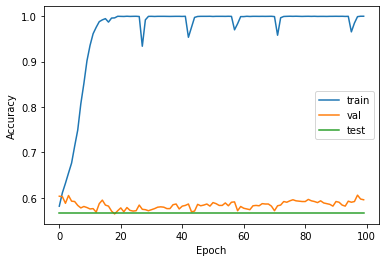

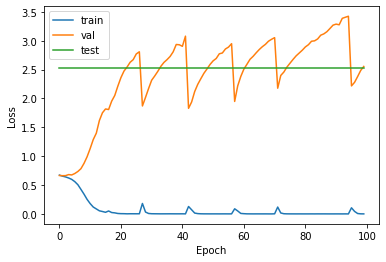

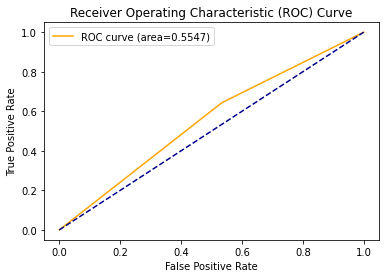

              precision    recall  f1-score   support

           0       0.50      0.47      0.48       553
           1       0.61      0.64      0.63       714

    accuracy                           0.57      1267
   macro avg       0.56      0.55      0.55      1267
weighted avg       0.56      0.57      0.56      1267


Test Loss: 2.5327870697135895
Test Accuracy: 0.5659037
ROC-AUC Score: 0.5547016274864376
Best model's epoch: 98


In [14]:
history = pd.read_csv("model-weights/liarDataset/lstm-128_glove/fakenews-classifier-model-lstm-128_glove.log")
model = load_model("model-weights/liarDataset/lstm-128_glove/fakenews-classifier-model-lstm-128_glove-0098-0.605919.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 98)

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix_liar_news], input_length=max_length, trainable=False, mask_zero=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'lstm-128-128_glove', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 128)           117248    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 1,249,090
Trainable params: 249,090
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 45s 4ms/step - loss: 0.6706 - accuracy: 0.5890 - val_loss: 0.6732 - val_accuracy: 0.5810

Epoch 00001: val_accuracy improved fr

10240/10240 [==============================] - 44s 4ms/step - loss: 0.0306 - accuracy: 0.9902 - val_loss: 2.9614 - val_accuracy: 0.5935

Epoch 00026: val_accuracy did not improve from 0.60436

Epoch 00026: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 27/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0164 - accuracy: 0.9952 - val_loss: 3.2845 - val_accuracy: 0.6051

Epoch 00027: val_accuracy improved from 0.60436 to 0.60514, saving model to fakenews-classifier-model-lstm-128-128_glove-0027-0.605140.h5

Epoch 00027: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 28/100
10240/10240 [==============================] - 43s 4ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 3.2928 - val_accuracy: 0.5880

Epoch 00028: val_accuracy did not improve from 0.60514

Epoch 00028: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 29/100
10240/10240 [==============================] - 44s 4ms/step - loss: 

10240/10240 [==============================] - 44s 4ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 4.1610 - val_accuracy: 0.5724

Epoch 00055: val_accuracy did not improve from 0.60514

Epoch 00055: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 56/100
10240/10240 [==============================] - 43s 4ms/step - loss: 0.0013 - accuracy: 0.9992 - val_loss: 4.2029 - val_accuracy: 0.5732

Epoch 00056: val_accuracy did not improve from 0.60514

Epoch 00056: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 57/100
10240/10240 [==============================] - 43s 4ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 4.3057 - val_accuracy: 0.5717

Epoch 00057: val_accuracy did not improve from 0.60514

Epoch 00057: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 58/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 4.3539 - val_accuracy: 0.5748

Epoch 00058: v

10240/10240 [==============================] - 44s 4ms/step - loss: 0.0390 - accuracy: 0.9895 - val_loss: 1.9912 - val_accuracy: 0.5701

Epoch 00084: val_accuracy did not improve from 0.60514

Epoch 00084: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 85/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0903 - accuracy: 0.9679 - val_loss: 2.4046 - val_accuracy: 0.5810

Epoch 00085: val_accuracy did not improve from 0.60514

Epoch 00085: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 86/100
10240/10240 [==============================] - 44s 4ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 2.9482 - val_accuracy: 0.5802

Epoch 00086: val_accuracy did not improve from 0.60514

Epoch 00086: saving model to fakenews-classifier-model-lstm-128-128_glove.h5
Epoch 87/100
10240/10240 [==============================] - 43s 4ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 3.2035 - val_accuracy: 0.5802

Epoch 00087: v

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 128)           117248    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 1,249,090
Trainable params: 249,090
Non-trainable params: 1,000,000
_________________________________________________________________
1267/1267 [==============================] - 2s 1ms/sample - loss: 3.5648 - accuracy: 0.5470


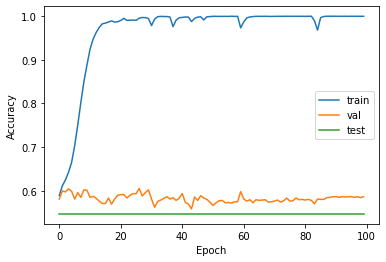

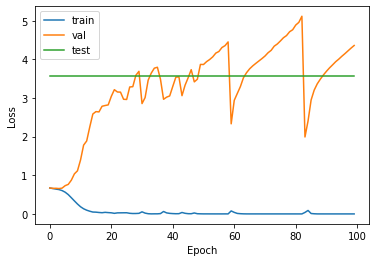

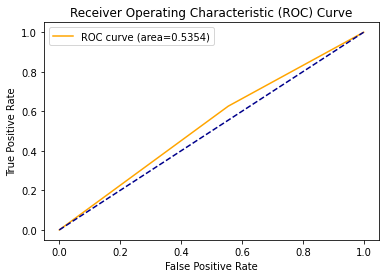

              precision    recall  f1-score   support

           0       0.48      0.44      0.46       553
           1       0.59      0.63      0.61       714

    accuracy                           0.55      1267
   macro avg       0.54      0.54      0.54      1267
weighted avg       0.54      0.55      0.54      1267


Test Loss: 3.564832650871849
Test Accuracy: 0.5469613
ROC-AUC Score: 0.535448356557813
Best model's epoch: 27


In [15]:
history = pd.read_csv("model-weights/liarDataset/lstm-128-128_glove/fakenews-classifier-model-lstm-128-128_glove.log")
model = load_model("model-weights/liarDataset/lstm-128-128_glove/fakenews-classifier-model-lstm-128-128_glove-0027-0.605140.h5")
model.summary()

evaluate_model(model, test_padded, y_test, history)

print("Best model's epoch:", 27)

## HASTA AQUI

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix_liar_news], input_length=max_length, trainable=False, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'Bilstm-128-128_glove', train_padded, y_train, valid_padded, y_valid)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 514       
Total params: 1,235,010
Trainable params: 235,010
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 10240 samples, validate on 1284 samples
Epoch 1/100
10240/10240 [==============================] - 41s 4ms/step - loss: 0.6702 - accuracy: 0.5938 - val_loss: 0.6662 - val_accuracy: 0.5810

Epoch 00001: val_accuracy improved from -inf to 0.58100, saving model to fakenews-classifier-model-Bilstm-128-128_glove-0001-0.580997.h5

Epoch 00001: saving model to fa


Epoch 00025: val_accuracy did not improve from 0.60514

Epoch 00025: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 26/100
10240/10240 [==============================] - 39s 4ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 2.5860 - val_accuracy: 0.6044

Epoch 00026: val_accuracy did not improve from 0.60514

Epoch 00026: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 27/100
10240/10240 [==============================] - 39s 4ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 2.7263 - val_accuracy: 0.5872

Epoch 00027: val_accuracy did not improve from 0.60514

Epoch 00027: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 28/100
10240/10240 [==============================] - 39s 4ms/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 1.6938 - val_accuracy: 0.5779

Epoch 00028: val_accuracy did not improve from 0.60514

Epoch 00028: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 29/

10240/10240 [==============================] - 39s 4ms/step - loss: 9.9343e-04 - accuracy: 0.9994 - val_loss: 3.7871 - val_accuracy: 0.5857

Epoch 00083: val_accuracy did not improve from 0.60514

Epoch 00083: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 84/100
10240/10240 [==============================] - 39s 4ms/step - loss: 9.0185e-04 - accuracy: 0.9995 - val_loss: 3.8446 - val_accuracy: 0.5903

Epoch 00084: val_accuracy did not improve from 0.60514

Epoch 00084: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 85/100
10240/10240 [==============================] - 39s 4ms/step - loss: 0.0669 - accuracy: 0.9783 - val_loss: 1.7605 - val_accuracy: 0.5896

Epoch 00085: val_accuracy did not improve from 0.60514

Epoch 00085: saving model to fakenews-classifier-model-Bilstm-128-128_glove.h5
Epoch 86/100
10240/10240 [==============================] - 39s 4ms/step - loss: 0.0827 - accuracy: 0.9684 - val_loss: 2.1914 - val_accuracy: 0.5787



In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Conv1D(filters=32, kernel_size=4, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=64, kernel_size=4, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters=128, kernel_size=4, activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model = compile_model(model)
model = fit_model(model, 'conv-32-64-128-dense-128', train_padded, y_train, valid_padded, y_valid)

In [11]:
inputs = keras.Input(shape=(max_length,))

embedding = Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True)(inputs)

x1 = Conv1D(filters=32, kernel_size=5, activation=None)(embedding)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
conv_1 = MaxPooling1D()(x1)

x2 = Conv1D(filters=32, kernel_size=5, activation=None)(embedding)
x2 = BatchNormalization()(x1)
x2 = Activation('relu')(x1)
conv_2 = MaxPooling1D()(x2)

block_1_output = Concatenate()([conv_1, conv_2])

x = LSTM(128)(block_1_output)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model = compile_model(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 150)      1500000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 46, 32)       24032       embedding_7[0][0]                
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 46, 32)       128         conv1d_12[0][0]                  
____________________________________________________________________________________________

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=150, input_length=max_length, trainable=True))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())

model.add(Dense(128))
model.add(Dense(2, activation='softmax'))
model = compile_model(model)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 150)           1500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           110080    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 1,626,850
Trainable params: 1,626,850
Non-trainable params: 0
_________________________________________________________________
